In [2]:
# --- STEP 1: Environment Setup & Sanity Check ---

# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set visual styles for easier analysis
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 100)     
plt.style.use('ggplot')


file_path = 'data/raw/application_train.csv' 

# 3. Load Data
print(f"Attempting to load data from: {file_path}...")

try:
    df = pd.read_csv(file_path)
    print("✅ Data Loaded Successfully!")
except FileNotFoundError:
    print("❌ ERROR: File not found. Please check the file path and name.")

# 4. The Sanity Check
if 'df' in locals():
    print(f"\n--- 📊 Dataset Dimensions ---")
    print(f"Rows (Applicants): {df.shape[0]}")
    print(f"Columns (Features): {df.shape[1]}")

    print(f"\n--- 🧐 Column Data Types ---")
    print(df.dtypes.value_counts())

    print(f"\n--- 🔍 Missing Values Snapshot (Top 10) ---")
    missing = df.isnull().sum().sort_values(ascending=False).head(10)
    print(missing)
    
    # 5. Peak at the Target Variable (Crucial for Step 2)
    if 'TARGET' in df.columns:
        print(f"\n--- 🎯 Target Distribution (The Imbalance) ---")
        print(df['TARGET'].value_counts(normalize=True) * 100)
    else:
        print("\n⚠️ WARNING: 'TARGET' column not found. Is this the Test set?")

Attempting to load data from: data/raw/application_train.csv...
✅ Data Loaded Successfully!

--- 📊 Dataset Dimensions ---
Rows (Applicants): 307511
Columns (Features): 122

--- 🧐 Column Data Types ---
float64    65
int64      41
object     16
Name: count, dtype: int64

--- 🔍 Missing Values Snapshot (Top 10) ---
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
COMMONAREA_MEDI             214865
NONLIVINGAPARTMENTS_MEDI    213514
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_AVG     213514
FONDKAPREMONT_MODE          210295
LIVINGAPARTMENTS_AVG        210199
LIVINGAPARTMENTS_MEDI       210199
LIVINGAPARTMENTS_MODE       210199
dtype: int64

--- 🎯 Target Distribution (The Imbalance) ---
TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64


C:\Users\harsh\AppData\Local\Temp\ipykernel_26400\2112278431.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TARGET', data=df, palette='viridis')


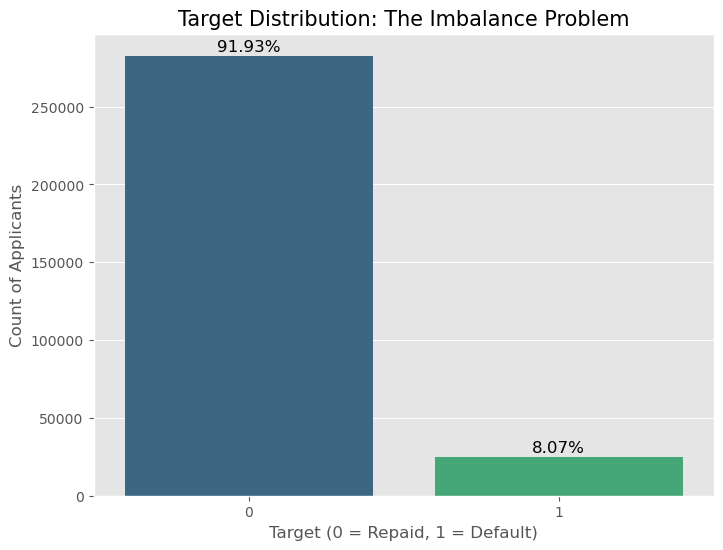

--- 📉 The Baseline to Beat ---
Null Accuracy (Predicting '0' for everyone): 0.9193
We must beat this using ROC-AUC, not Accuracy.


In [3]:
# --- STEP 2: The Imbalance & Metric Strategy ---

# 1. Visualize the Class Imbalance
plt.figure(figsize=(8, 6))
sns.countplot(x='TARGET', data=df, palette='viridis')
plt.title('Target Distribution: The Imbalance Problem', fontsize=15)
plt.xlabel('Target (0 = Repaid, 1 = Default)', fontsize=12)
plt.ylabel('Count of Applicants', fontsize=12)

# Add percentage labels
total = len(df)
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width()/2.,
            height + 3000,
            '{:1.2f}%'.format(100 * height/total),
            ha="center", fontsize=12)
plt.show()

class_0_count = df['TARGET'].value_counts()[0]
class_1_count = df['TARGET'].value_counts()[1]
null_accuracy = class_0_count / (class_0_count + class_1_count)

print(f"--- 📉 The Baseline to Beat ---")
print(f"Null Accuracy (Predicting '0' for everyone): {null_accuracy:.4f}")
print("We must beat this using ROC-AUC, not Accuracy.")

from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(y_true, y_pred_prob, model_name="Model"):
    """
    Plots the ROC Curve and prints the AUC score.
    """
    auc = roc_auc_score(y_true, y_pred_prob)
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})', color='blue', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2) # Random guess line
    plt.xlabel('False Positive Rate (False Alarms)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    return auc

--- 🐛 inspecting DAYS_EMPLOYED ---
count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64


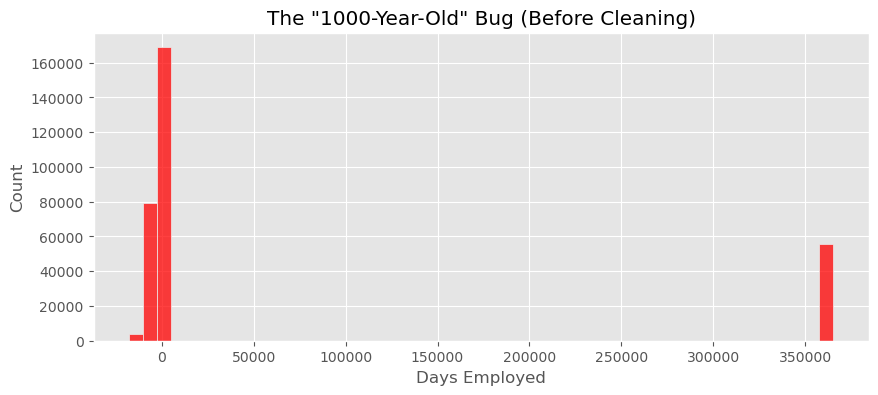

C:\Users\harsh\AppData\Local\Temp\ipykernel_26400\1414017850.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)



✅ Anomaly Handled. 55374 rows flagged.


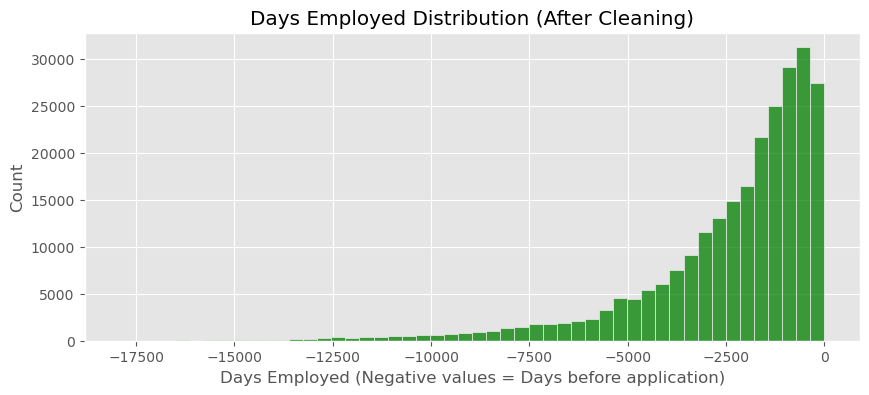


--- 🎂 Age Statistics ---
count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: AGE_YEARS, dtype: float64


In [4]:

print("--- 🐛 inspecting DAYS_EMPLOYED ---")
print(df['DAYS_EMPLOYED'].describe())

# Visualizing the Anomaly
plt.figure(figsize=(10, 4))
sns.histplot(df['DAYS_EMPLOYED'], bins=50, kde=False, color='red')
plt.title('The "1000-Year-Old" Bug (Before Cleaning)')
plt.xlabel('Days Employed')
plt.show()

# 2. The Strategy: Flag and Replace
df['DAYS_EMPLOYED_ANOM'] = df['DAYS_EMPLOYED'] == 365243

# Replace the magic number with NaN (Not a Number) so it doesn't skew stats
df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

print(f"\n✅ Anomaly Handled. {df['DAYS_EMPLOYED_ANOM'].sum()} rows flagged.")

# 3. Visualize After Cleaning
plt.figure(figsize=(10, 4))
sns.histplot(df['DAYS_EMPLOYED'].dropna(), bins=50, kde=False, color='green')
plt.title('Days Employed Distribution (After Cleaning)')
plt.xlabel('Days Employed (Negative values = Days before application)')
plt.show()

# 4. Quick Sanity Check on "Age" (DAYS_BIRTH)
df['AGE_YEARS'] = df['DAYS_BIRTH'] / -365
print(f"\n--- 🎂 Age Statistics ---")
print(df['AGE_YEARS'].describe())

In [4]:
print("--- 🔍 Why we picked our targets ---")
targets = ['OWN_CAR_AGE', 'EXT_SOURCE_1', 'TOTALAREA_MODE', 'EXT_SOURCE_3']
for col in targets:
    print(f"{col}: {df[col].isnull().mean()*100:.1f}% Missing")

--- 🔍 Why we picked our targets ---
OWN_CAR_AGE: 66.0% Missing
EXT_SOURCE_1: 56.4% Missing
TOTALAREA_MODE: 48.3% Missing
EXT_SOURCE_3: 19.8% Missing


In [5]:
# --- STEP 4: Informative Missingness ---


cols_to_flag = ['OWN_CAR_AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_3', 'TOTALAREA_MODE']

print(f"--- 🚩 Creating Missing Flags for: {cols_to_flag} ---")

for col in cols_to_flag:
    # Create a new column name, e.g., 'OWN_CAR_AGE_MISSING'
    new_col_name = f'{col}_MISSING'
    
    # 1 if missing, 0 if present
    df[new_col_name] = df[col].isnull().astype(int)
    
    # Check the correlation with the Target
    # Does "Having missing data" make you risky?
    corr = df[[new_col_name, 'TARGET']].corr().iloc[0, 1]
    print(f"Created {new_col_name} | Correlation with Default: {corr:.4f}")

# 2. Handling the original columns (Imputation Strategy)
# For the original columns, we still need to fill the holes so the code doesn't crash later.
# We will use 'Median' for numerical stability, but the model will rely on the Flags we just created.

for col in cols_to_flag:
    if col in df.columns:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

print("\n✅ Missing values flagged and original holes filled with Median.")

# 3. Sanity Check
# Let's verify OWN_CAR_AGE is full
print(f"Missing values in OWN_CAR_AGE after fill: {df['OWN_CAR_AGE'].isnull().sum()}")

--- 🚩 Creating Missing Flags for: ['OWN_CAR_AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_3', 'TOTALAREA_MODE'] ---
Created OWN_CAR_AGE_MISSING | Correlation with Default: 0.0218
Created EXT_SOURCE_1_MISSING | Correlation with Default: 0.0186
Created EXT_SOURCE_3_MISSING | Correlation with Default: 0.0226
Created TOTALAREA_MODE_MISSING | Correlation with Default: 0.0412

✅ Missing values flagged and original holes filled with Median.
Missing values in OWN_CAR_AGE after fill: 0


C:\Users\harsh\AppData\Local\Temp\ipykernel_26400\4169945401.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)


C:\Users\harsh\AppData\Local\Temp\ipykernel_10728\1911319232.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_data.head(20).index, y=missing_data.head(20).values, palette='Reds_r')


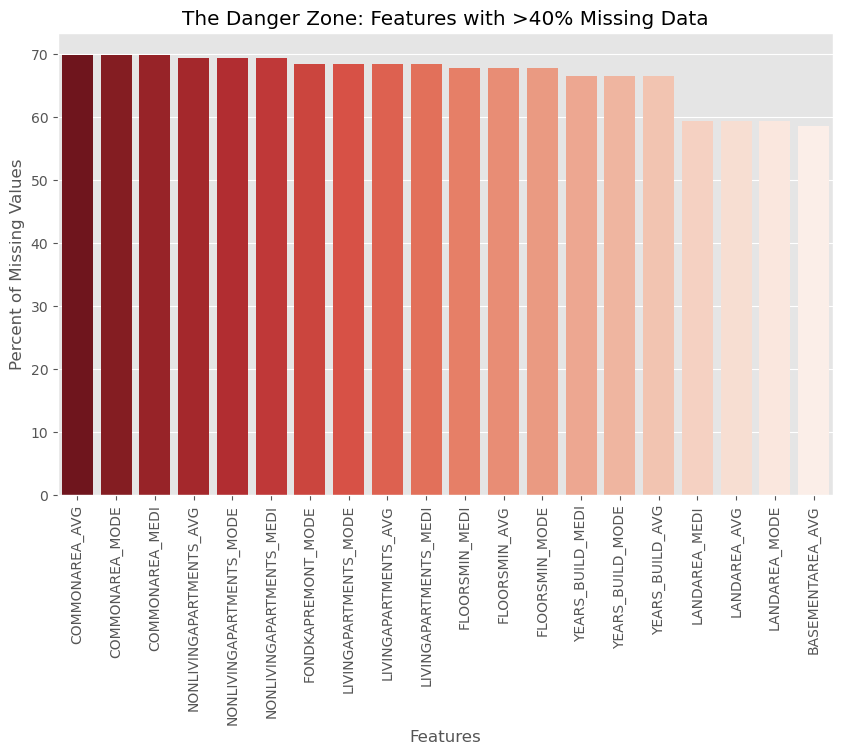

--- 🔍 Why we picked our targets ---
OWN_CAR_AGE: 0.0% Missing
EXT_SOURCE_1: 0.0% Missing
TOTALAREA_MODE: 0.0% Missing
EXT_SOURCE_3: 0.0% Missing


In [7]:
missing_data = df.isnull().sum() / len(df) * 100
missing_data = missing_data[missing_data > 0] # Only look at columns with missing data
missing_data.sort_values(inplace=True, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_data.head(20).index, y=missing_data.head(20).values, palette='Reds_r')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Percent of Missing Values')
plt.title('The Danger Zone: Features with >40% Missing Data')
plt.show()

print("--- 🔍 Why we picked our targets ---")
targets = ['OWN_CAR_AGE', 'EXT_SOURCE_1', 'TOTALAREA_MODE', 'EXT_SOURCE_3']
for col in targets:
    print(f"{col}: {df[col].isnull().mean()*100:.1f}% Missing")

In [6]:
# --- LOGIC CHECK: Redundant Missingness ---


col_a = 'COMMONAREA_AVG'
col_b = 'NONLIVINGAPARTMENTS_AVG'

missing_a = df[col_a].isnull()
missing_b = df[col_b].isnull()

# Check overlap
overlap = (missing_a & missing_b).sum()
total_missing_a = missing_a.sum()

print(f"Rows where {col_a} is missing: {total_missing_a}")
print(f"Rows where BOTH are missing: {overlap}")
print(f"Overlap Percentage: {overlap / total_missing_a * 100:.1f}%")

print("\n💡 Conclusion: If one is missing, the other is almost always missing.")
print("We don't need duplicate flags.")

Rows where COMMONAREA_AVG is missing: 214865
Rows where BOTH are missing: 209375
Overlap Percentage: 97.4%

💡 Conclusion: If one is missing, the other is almost always missing.
We don't need duplicate flags.


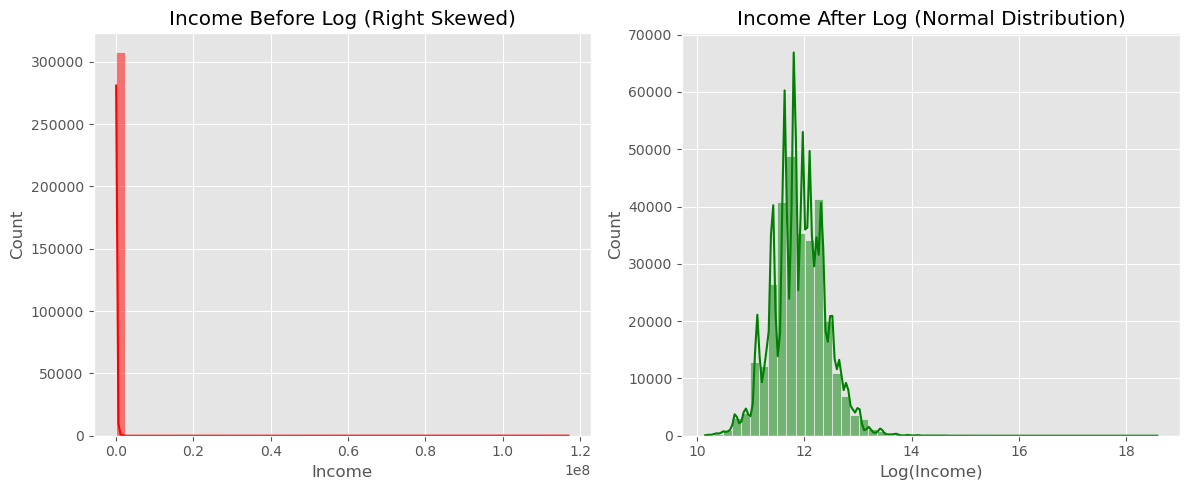

Skewness Before: 391.56 (Terrible)
Skewness After:  0.17  (Much Better!)


In [7]:
# --- STEP 5: Outlier Engineering (Log Transformation) ---


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# We limit x-axis to 1M just to make the plot readable, otherwise it's just a flat line
sns.histplot(df['AMT_INCOME_TOTAL'], bins=50, kde=True, color='red')
plt.title('Income Before Log (Right Skewed)')
plt.xlabel('Income')

# 2. Apply Log Transformation
# np.log1p calculates log(1 + x) to avoid errors if income is 0
df['AMT_INCOME_TOTAL_LOG'] = np.log1p(df['AMT_INCOME_TOTAL'])

# 3. Visualize the Solution (Normal-ish Distribution)
plt.subplot(1, 2, 2)
sns.histplot(df['AMT_INCOME_TOTAL_LOG'], bins=50, kde=True, color='green')
plt.title('Income After Log (Normal Distribution)')
plt.xlabel('Log(Income)')

plt.tight_layout()
plt.show()

# 4. Compare Skewness Score
# 0 = Perfect Normal Distribution. High positive = Right Skew.
skew_before = df['AMT_INCOME_TOTAL'].skew()
skew_after = df['AMT_INCOME_TOTAL_LOG'].skew()

print(f"Skewness Before: {skew_before:.2f} (Terrible)")
print(f"Skewness After:  {skew_after:.2f}  (Much Better!)")

✅ 4 Domain Features Created.


C:\Users\harsh\AppData\Local\Temp\ipykernel_14212\631179636.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['TARGET'] == 0, 'ANNUITY_INCOME_PERCENT'], label='Target=0 (Repaid)', shade=True, clip=(0,0.5))
C:\Users\harsh\AppData\Local\Temp\ipykernel_14212\631179636.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['TARGET'] == 1, 'ANNUITY_INCOME_PERCENT'], label='Target=1 (Default)', shade=True, clip=(0,0.5))


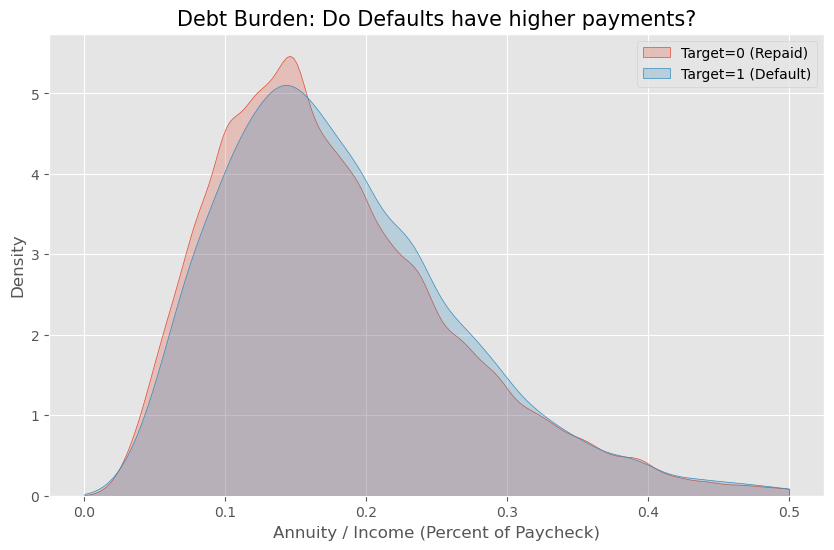

--- 📊 Correlation with Target ---
TARGET                    1.000000
ANNUITY_INCOME_PERCENT    0.014265
CREDIT_INCOME_PERCENT    -0.007727
CREDIT_TERM              -0.032102
GOODS_LOAN_RATIO         -0.065407
Name: TARGET, dtype: float64


In [9]:
# --- STEP 6: Financial Domain Features ---

# 1. Create the Domain Features
# How much loan are you asking for relative to your salary?
df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

# How much of your monthly check goes to the bank?
df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

# How long is the payment plan? (Roughly in months)
df['CREDIT_TERM'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']

# Did you pay extra or take cash out?
df['GOODS_LOAN_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_CREDIT']

print("✅ 4 Domain Features Created.")

# 2. Visualize the Risk (Annuity-to-Income)
# We limit the range to 0.5 (50%) because outliers make the chart unreadable
plt.figure(figsize=(10, 6))
sns.kdeplot(df.loc[df['TARGET'] == 0, 'ANNUITY_INCOME_PERCENT'], label='Target=0 (Repaid)', shade=True, clip=(0,0.5))
sns.kdeplot(df.loc[df['TARGET'] == 1, 'ANNUITY_INCOME_PERCENT'], label='Target=1 (Default)', shade=True, clip=(0,0.5))

plt.title('Debt Burden: Do Defaults have higher payments?', fontsize=15)
plt.xlabel('Annuity / Income (Percent of Paycheck)')
plt.ylabel('Density')
plt.legend()
plt.show()

# 3. Correlation Check
# Let's see if our new features are actually useful
new_features = ['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'GOODS_LOAN_RATIO']
print("--- 📊 Correlation with Target ---")
print(df[new_features + ['TARGET']].corr()['TARGET'].sort_values(ascending=False))

C:\Users\harsh\AppData\Local\Temp\ipykernel_14212\2746578254.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['TARGET'] == 0, 'CREDIT_INCOME_PERCENT'], label='Target=0 (Repaid)', color='green', shade=True, clip=(0, 10))
C:\Users\harsh\AppData\Local\Temp\ipykernel_14212\2746578254.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['TARGET'] == 1, 'CREDIT_INCOME_PERCENT'], label='Target=1 (Default)', color='red', shade=True, clip=(0, 10))


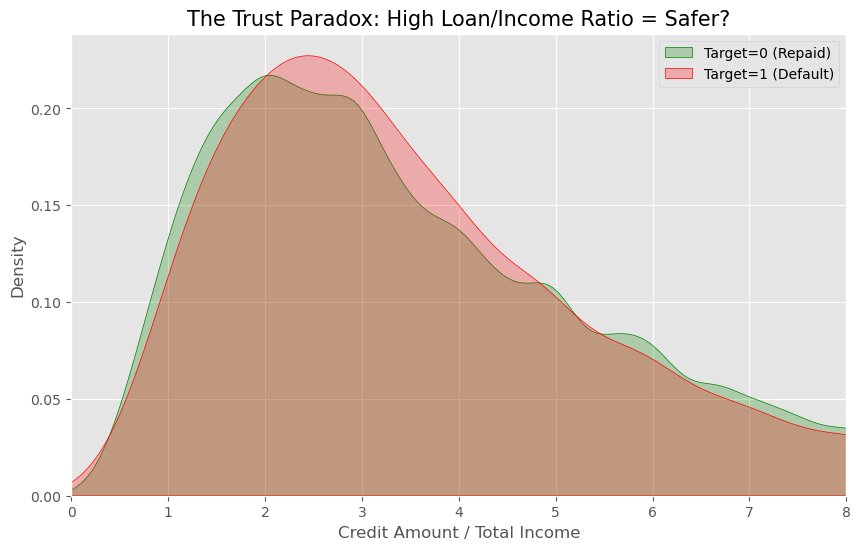

In [10]:
# --- VISUALIZATION: The Credit-Income Paradox ---

plt.figure(figsize=(10, 6))

# We clip the data at 10 because outliers make the chart unreadable
# Green = Repaid (Target 0), Red = Default (Target 1)
sns.kdeplot(df.loc[df['TARGET'] == 0, 'CREDIT_INCOME_PERCENT'], label='Target=0 (Repaid)', color='green', shade=True, clip=(0, 10))
sns.kdeplot(df.loc[df['TARGET'] == 1, 'CREDIT_INCOME_PERCENT'], label='Target=1 (Default)', color='red', shade=True, clip=(0, 10))

plt.title('The Trust Paradox: High Loan/Income Ratio = Safer?', fontsize=15)
plt.xlabel('Credit Amount / Total Income')
plt.ylabel('Density')
plt.xlim(0, 8) # Zoom in to see the shift
plt.legend()
plt.show()

⏳ Calculating correlations for all numeric features...

--- 🟢 Top 10 Negative Correlations (Safety Factors) ---
EXT_SOURCE_2         -0.160472
EXT_SOURCE_3         -0.155892
EXT_SOURCE_1         -0.098887
AGE_YEARS            -0.078239
GOODS_LOAN_RATIO     -0.065407
DAYS_EMPLOYED_ANOM   -0.045987
FLOORSMAX_AVG        -0.044003
FLOORSMAX_MEDI       -0.043768
FLOORSMAX_MODE       -0.043226
AMT_GOODS_PRICE      -0.039645
Name: TARGET, dtype: float64

--- 🔴 Top 10 Positive Correlations (Risk Factors) ---
DAYS_BIRTH                     0.078239
DAYS_EMPLOYED                  0.074958
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
Name: TARGET, dtype: float64


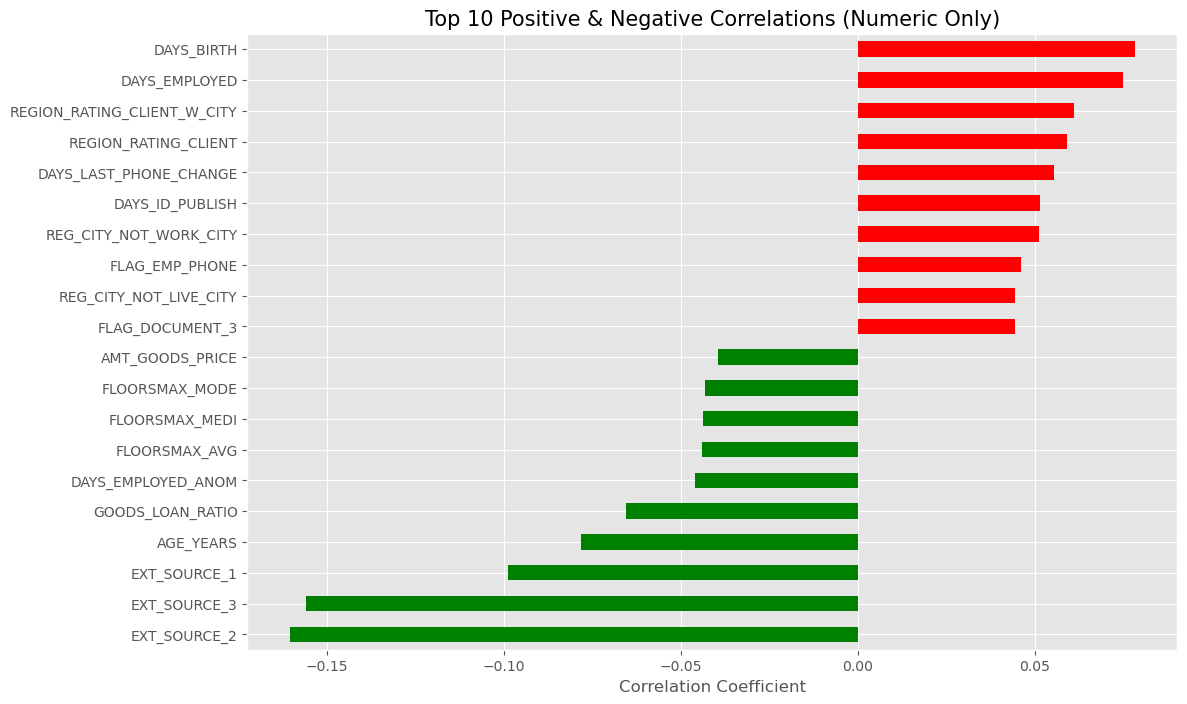

In [11]:
# --- ANALYSIS: Top 10 Correlations (Raw Data) ---

# 1. Calculate correlation of ONLY NUMERIC columns with 'TARGET'
# We added 'numeric_only=True' to fix the crash
print("⏳ Calculating correlations for all numeric features...")
correlations = df.corr(numeric_only=True)['TARGET'].sort_values()

# 2. Extract Top 10 Negative (Strongest "Safety" Signals)
top_negative = correlations.head(10)

# 3. Extract Top 10 Positive (Strongest "Risk" Signals)
# We drop 'TARGET' itself because correlation with itself is always 1.0
top_positive = correlations.tail(11).drop('TARGET')

# 4. Display the Results
print("\n--- 🟢 Top 10 Negative Correlations (Safety Factors) ---")
print(top_negative)

print("\n--- 🔴 Top 10 Positive Correlations (Risk Factors) ---")
print(top_positive.sort_values(ascending=False))

# 5. Visualizing the Top Correlations
plt.figure(figsize=(12, 8))
top_corr = pd.concat([top_negative, top_positive])
top_corr.sort_values().plot(kind='barh', color=['green']*10 + ['red']*10)
plt.title('Top 10 Positive & Negative Correlations (Numeric Only)', fontsize=15)
plt.xlabel('Correlation Coefficient')
plt.show()

✅ Polynomial Features Created.


C:\Users\harsh\AppData\Local\Temp\ipykernel_10728\658069000.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['TARGET'] == 0, 'EXT_SOURCE_MEAN'], label='Target=0 (Repaid)', color='blue', shade=True)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10728\658069000.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['TARGET'] == 1, 'EXT_SOURCE_MEAN'], label='Target=1 (Default)', color='red', shade=True)


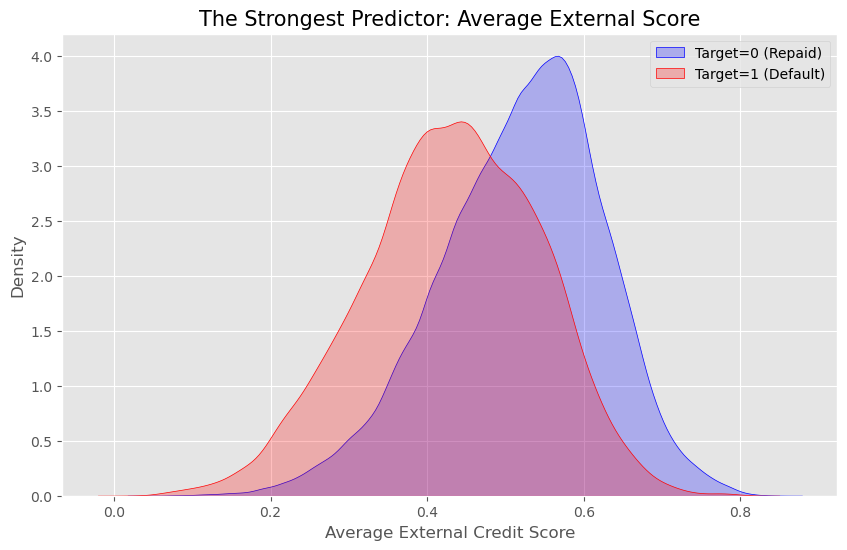

Old Feature Correlation (EXT_SOURCE_2): -0.1605
New Feature Correlation (EXT_SOURCE_MEAN): -0.2208


In [10]:
# --- STEP 7: Polynomial Feature Interaction ---

# 1. Create Polynomial Features

# Interaction 1: External Sources Mean (The "Community Score")
# If all 3 credit bureaus score you highly, you are extremely safe.
# We take the average of the 3 external scores.
df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

# Interaction 2: External Sources Multiplied
# Multiplying penalizes you heavily if even ONE score is bad (e.g., 0.9 * 0.9 * 0.1 = 0.08)
df['EXT_SOURCE_MULT'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

# Interaction 3: Income per Age
# High income at a young age is a strong signal of talent/risk-taking.
df['INCOME_PER_AGE'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH'] 

print("✅ Polynomial Features Created.")

# 2. Visualize the "Super Feature" (EXT_SOURCE_MEAN)
plt.figure(figsize=(10, 6))
# Blue = Repaid, Red = Default
sns.kdeplot(df.loc[df['TARGET'] == 0, 'EXT_SOURCE_MEAN'], label='Target=0 (Repaid)', color='blue', shade=True)
sns.kdeplot(df.loc[df['TARGET'] == 1, 'EXT_SOURCE_MEAN'], label='Target=1 (Default)', color='red', shade=True)

plt.title('The Strongest Predictor: Average External Score', fontsize=15)
plt.xlabel('Average External Credit Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# 3. Check Correlations (Did we beat the old features?)
# We compare the new "Mean" feature against the single best "Raw" feature
corr_old = df['EXT_SOURCE_2'].corr(df['TARGET'])
corr_new = df['EXT_SOURCE_MEAN'].corr(df['TARGET'])

print(f"Old Feature Correlation (EXT_SOURCE_2): {corr_old:.4f}")
print(f"New Feature Correlation (EXT_SOURCE_MEAN): {corr_new:.4f}")

C:\Users\harsh\AppData\Local\Temp\ipykernel_10728\1289186229.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['TARGET'] == 0, 'EXT_SOURCE_MULT'], label='Target=0 (Repaid)', color='green', shade=True)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10728\1289186229.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['TARGET'] == 1, 'EXT_SOURCE_MULT'], label='Target=1 (Default)', color='red', shade=True)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10728\1289186229.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['TARGET'] == 0, 'INCOME_PER_AGE'], label='Target=0 (Repaid)', color='blue', sha

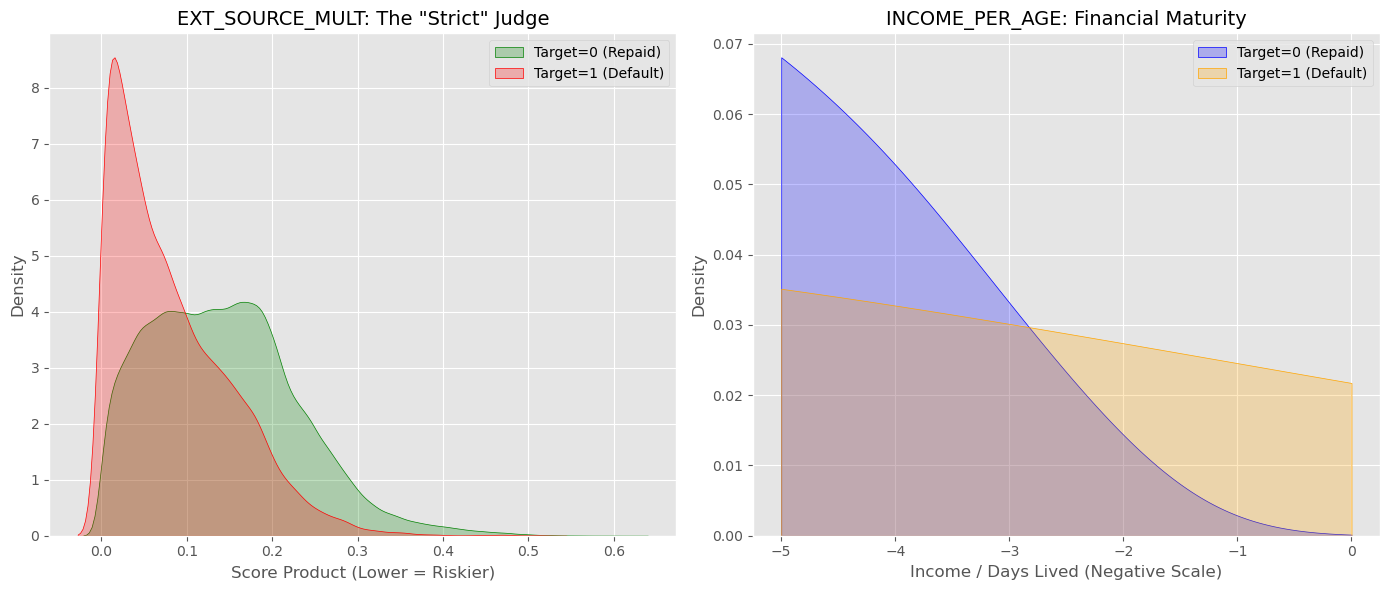

--- 📊 New Feature Power Rankings ---
Correlation (EXT_SOURCE_MULT): -0.1897
Correlation (INCOME_PER_AGE):  -0.0089


In [13]:
# --- VISUALIZATION: The Other 2 Polynomial Features ---

plt.figure(figsize=(14, 6))

# 1. EXT_SOURCE_MULT (The "Strict" Score)
plt.subplot(1, 2, 1)
# Green = Repaid, Red = Default
sns.kdeplot(df.loc[df['TARGET'] == 0, 'EXT_SOURCE_MULT'], label='Target=0 (Repaid)', color='green', shade=True)
sns.kdeplot(df.loc[df['TARGET'] == 1, 'EXT_SOURCE_MULT'], label='Target=1 (Default)', color='red', shade=True)
plt.title('EXT_SOURCE_MULT: The "Strict" Judge', fontsize=14)
plt.xlabel('Score Product (Lower = Riskier)')
plt.ylabel('Density')
plt.legend()

# 2. INCOME_PER_AGE (The "Potential" Score)
plt.subplot(1, 2, 2)
# We clip the data between -5 and 0 because outliers (billionaires) ruin the scale
# Note: The x-axis is negative because DAYS_BIRTH is negative.
sns.kdeplot(df.loc[df['TARGET'] == 0, 'INCOME_PER_AGE'], label='Target=0 (Repaid)', color='blue', shade=True, clip=(-5, 0))
sns.kdeplot(df.loc[df['TARGET'] == 1, 'INCOME_PER_AGE'], label='Target=1 (Default)', color='orange', shade=True, clip=(-5, 0))

plt.title('INCOME_PER_AGE: Financial Maturity', fontsize=14)
plt.xlabel('Income / Days Lived (Negative Scale)')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# 3. Check Correlations
print("--- 📊 New Feature Power Rankings ---")
print(f"Correlation (EXT_SOURCE_MULT): {df['EXT_SOURCE_MULT'].corr(df['TARGET']):.4f}")
print(f"Correlation (INCOME_PER_AGE):  {df['INCOME_PER_AGE'].corr(df['TARGET']):.4f}")

In [14]:
# --- STEP 8: Categorical Encoding (One-Hot) ---

# 1. Identify Text Columns
# We only want to transform columns that are technically 'objects' (strings)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"--- 🔠 Encoding {len(categorical_cols)} Text Columns ---")

# 2. Apply One-Hot Encoding
# pd.get_dummies turns "Gender" into "Gender_M" and "Gender_F" automatically.
print("... Processing (This creates many new columns) ...")
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 3. Verify the "Explosion"
# We expect the column count to double because every text option gets its own column.
print(f"✅ Encoding Complete!")
print(f"Original Columns: {df.shape[1]}")
print(f"New Columns:      {df_encoded.shape[1]}")

# 4. Save the Final Clean Dataset (Optional but recommended)
# We use a pickle file because it saves faster and preserves the data types better than CSV
# df_encoded.to_pickle('data/processed/train_ready.pkl')
# print("💾 Saved processed data to data/processed/train_ready.pkl")

--- 🔠 Encoding 16 Text Columns ---
... Processing (This creates many new columns) ...
✅ Encoding Complete!
Original Columns: 132
New Columns:      240


In [15]:
# --- STEP 9: Multicollinearity Removal ---

# 1. Calculate the Correlation Matrix (This is heavy math for 240 cols!)
print("⏳ Calculating correlation matrix... (This might take 30 seconds)")
# We use abs() because -0.99 is just as bad as +0.99
corr_matrix = df_encoded.corr().abs()

# 2. Select Upper Triangle of the matrix
# (Because Matrix is symmetrical, [A, B] is same as [B, A])
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 3. Find Columns with Correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"--- ✂️ Found {len(to_drop)} Redundant Columns to Drop ---")
print(to_drop[:10]) # Print first 10 names

# 4. The Purge: Drop them
df_cleaned = df_encoded.drop(columns=to_drop)

print(f"\n✅ Dropped {len(to_drop)} columns.")
print(f"Old Shape: {df_encoded.shape}")
print(f"New Shape: {df_cleaned.shape}")

# 5. Save Checkpoint
# df_cleaned.to_pickle('data/processed/train_no_duplicates.pkl')

⏳ Calculating correlation matrix... (This might take 30 seconds)
--- ✂️ Found 37 Redundant Columns to Drop ---
['AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE']

✅ Dropped 37 columns.
Old Shape: (307511, 240)
New Shape: (307511, 203)


In [16]:
# --- STEP 10: Class Imbalance Strategy ---

# 1. Count the classes
count_0 = df_cleaned[df_cleaned['TARGET'] == 0].shape[0]
count_1 = df_cleaned[df_cleaned['TARGET'] == 1].shape[0]

# 2. Calculate the Ratio
# This tells us how many "Safe" people there are for every 1 "Risky" person
scale_pos_weight_value = count_0 / count_1

print(f"--- ⚖️ The Balancing Act ---")
print(f"Count (0): {count_0}")
print(f"Count (1): {count_1}")
print(f"Ratio (Weight): {scale_pos_weight_value:.4f}")

print("\n--- 📝 Action Item ---")
print(f"When we train XGBoost in Step 12, we will set: scale_pos_weight = {scale_pos_weight_value:.2f}")
print("This forces the model to treat 1 Default as equally important as ~11 Repayments.")

--- ⚖️ The Balancing Act ---
Count (0): 282686
Count (1): 24825
Ratio (Weight): 11.3872

--- 📝 Action Item ---
When we train XGBoost in Step 12, we will set: scale_pos_weight = 11.39
This forces the model to treat 1 Default as equally important as ~11 Repayments.


In [17]:
# --- STEP 11: Data Splitting & Linear Regression Baseline ---
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score

# 1. Prepare X (Features) and y (Target)
# Drop TARGET from X, and also drop SK_ID_CURR (Customer ID is not a predictor)
X = df_cleaned.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_cleaned['TARGET']

# 2. Split Data (80% Train, 20% Test)
# stratify=y ensures we keep the same 92/8 ratio in both sets
print("⏳ Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Handle Missing Values (Imputation)
# Machine Learning models (except trees) crash on NaNs. We fill gaps with the Median.
print("⏳ Filling missing values (Imputation)...")
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# 4. Scale the Data (Standardization)
# Linear Regression and SVM get confused if Income is 1,000,000 and Age is 0.5.
# We scale everything to be roughly between -1 and 1.
print("⏳ Scaling data...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# 5. Train Linear Regression (The "Wrong" Model)
print("⏳ Training Linear Regression...")
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# 6. Evaluate
# We predict raw numbers (not probabilities, because Linear Reg doesn't know prob)
y_pred_raw = lin_reg.predict(X_test_scaled)

# Calculate AUC (Rank order check)
auc_score = roc_auc_score(y_test, y_pred_raw)

print(f"\n--- 📉 Linear Regression Results ---")
print(f"ROC-AUC Score: {auc_score:.4f}")
print(f"Min Prediction: {y_pred_raw.min():.4f} (Should be 0)")
print(f"Max Prediction: {y_pred_raw.max():.4f} (Should be 1)")
print("Result: The model predicts negative probabilities and probabilities > 100%.")
print("Conclusion: Mathematically invalid for classification, but sets our AUC floor.")

⏳ Splitting data...
⏳ Filling missing values (Imputation)...
⏳ Scaling data...
⏳ Training Linear Regression...

--- 📉 Linear Regression Results ---
ROC-AUC Score: 0.7430
Min Prediction: -1.1962 (Should be 0)
Max Prediction: 0.4896 (Should be 1)
Result: The model predicts negative probabilities and probabilities > 100%.
Conclusion: Mathematically invalid for classification, but sets our AUC floor.


In [18]:
# --- STEP 12: Logistic Regression (The Correct Baseline) ---
from sklearn.linear_model import LogisticRegression

# 1. Train Logistic Regression
# C=0.0001 is a regularization parameter (prevents overfitting on our many features)
# class_weight='balanced' automatically handles the 92/8 imbalance!
print("⏳ Training Logistic Regression...")
log_reg = LogisticRegression(C=0.0001, class_weight='balanced', max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# 2. Predict PROBABILITIES (Not just 0 or 1)
# We want the probability of being class 1 (Default)
y_pred_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# 3. Evaluate
auc_score_log = roc_auc_score(y_test, y_pred_prob)

print(f"\n--- 📊 Logistic Regression Results ---")
print(f"ROC-AUC Score: {auc_score_log:.4f}")
print(f"Min Prediction: {y_pred_prob.min():.4f} (Should be near 0)")
print(f"Max Prediction: {y_pred_prob.max():.4f} (Should be near 1)")

# 4. Sanity Check
if auc_score_log > 0.7471:
    print("\n✅ Success! Logistic Regression beat the Linear Regression baseline.")
else:
    print("\n⚠️ Interesting... Linear Regression was stronger? (Rare but possible)")

⏳ Training Logistic Regression...

--- 📊 Logistic Regression Results ---
ROC-AUC Score: 0.7514
Min Prediction: 0.0000 (Should be near 0)
Max Prediction: 0.9645 (Should be near 1)

✅ Success! Logistic Regression beat the Linear Regression baseline.


In [19]:
# --- STEP 13: Support Vector Machine (Linear SVM) ---
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score

print("⏳ Training Linear SVM (This measures the geometric margin)...")

# 1. Define the SVM
# class_weight='balanced' handles the 92/8 imbalance
# dual=False is explicitly recommended when n_samples > n_features
svm = LinearSVC(class_weight='balanced', dual=False, random_state=42, max_iter=1000)

# 2. Train
# SVM finds the "widest street" (margin) between the two classes
svm.fit(X_train_scaled, y_train)

# 3. Predict Scores
# SVMs don't output probabilities like LogReg. They output a "Distance to Boundary".
# The further you are from the boundary, the more confident the model is.
y_pred_svm_score = svm.decision_function(X_test_scaled)

# 4. Evaluate
auc_svm = roc_auc_score(y_test, y_pred_svm_score)

print(f"\n--- ⚔️ SVM Results ---")
print(f"ROC-AUC Score: {auc_svm:.4f}")

# 5. Compare with Logistic Regression
# (Checking if the variable exists from previous step)
if 'auc_score_log' in locals():
    print(f"Logistic Regression AUC: {auc_score_log:.4f}")
    
    if auc_svm > auc_score_log:
        print("Result: SVM is better. The geometric margin helped.")
    else:
        print("Result: SVM failed to beat LogReg.")
        print("Conclusion: The boundary isn't a straight line. We need Trees (Non-Linear models).")

⏳ Training Linear SVM (This measures the geometric margin)...

--- ⚔️ SVM Results ---
ROC-AUC Score: 0.7516
Logistic Regression AUC: 0.7514
Result: SVM is better. The geometric margin helped.


In [20]:
# --- STEP 14: Decision Tree (Single Tree) ---
from sklearn.tree import DecisionTreeClassifier

print("⏳ Training Decision Tree (This learns non-linear rules)...")

# 1. Define the Tree
# max_depth=8 prevents the tree from growing infinite branches and memorizing data
tree = DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42)

# 2. Train
tree.fit(X_train_scaled, y_train)

# 3. Predict Probabilities
y_pred_tree_prob = tree.predict_proba(X_test_scaled)[:, 1]

# 4. Evaluate
auc_tree = roc_auc_score(y_test, y_pred_tree_prob)

print(f"\n--- 🌳 Decision Tree Results ---")
print(f"ROC-AUC Score: {auc_tree:.4f}")

if 'auc_score_log' in locals():
    print(f"Logistic Regression AUC: {auc_score_log:.4f}")
    
    if auc_tree < auc_score_log:
        print("Result: The Single Tree is likely weaker than LogReg.")
        print("Reason: Single trees are unstable and 'high variance'. They need to be averaged.")
    else:
        print("Result: The Tree found powerful non-linear patterns!")

⏳ Training Decision Tree (This learns non-linear rules)...

--- 🌳 Decision Tree Results ---
ROC-AUC Score: 0.7242
Logistic Regression AUC: 0.7514
Result: The Single Tree is likely weaker than LogReg.
Reason: Single trees are unstable and 'high variance'. They need to be averaged.


In [21]:
# --- STEP 15: Random Forest (Ensemble Model) ---
from sklearn.ensemble import RandomForestClassifier

print("⏳ Training Random Forest (This involves 100 trees, might take a minute)...")

# 1. Define the Forest
# n_estimators=100 means we build 100 trees
# max_depth=10 limits each tree so they don't overfit individually
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=10, random_state=42, n_jobs=-1)

# 2. Train
rf.fit(X_train_scaled, y_train)

# 3. Predict Probabilities
y_pred_rf_prob = rf.predict_proba(X_test_scaled)[:, 1]

# 4. Evaluate
auc_rf = roc_auc_score(y_test, y_pred_rf_prob)

print(f"\n--- 🌲🌲 Random Forest Results ---")
print(f"ROC-AUC Score: {auc_rf:.4f}")

# 5. Comparison
if 'auc_tree' in locals():
    print(f"Single Tree Score: {auc_tree:.4f}")
    print(f"Improvement over Single Tree: {auc_rf - auc_tree:.4f}")

if 'auc_score_log' in locals():
    if auc_rf > auc_score_log:
        print("Result: The Forest beat Logistic Regression! Non-linear rules work.")
    else:
        print("Result: The Forest is close, but maybe Gradient Boosting is needed.")

⏳ Training Random Forest (This involves 100 trees, might take a minute)...

--- 🌲🌲 Random Forest Results ---
ROC-AUC Score: 0.7491
Single Tree Score: 0.7242
Improvement over Single Tree: 0.0249
Result: The Forest is close, but maybe Gradient Boosting is needed.


In [22]:
# Run this cell once to install the missing libraries
%pip install xgboost catboost lightgbm

Note: you may need to restart the kernel to use updated packages.


⏳ Training XGBoost...
✅ XGBoost AUC: 0.7611

⏳ Training CatBoost (This might be slower)...
✅ CatBoost AUC: 0.7691

⏳ Training LightGBM...


c:\Users\harsh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ LightGBM AUC: 0.7705

--- 🏁 Tournament Results ---
XGBoost: 0.7611
CatBoost: 0.7691
LightGBM: 0.7705

🏆 AND THE WINNER IS: LightGBM!


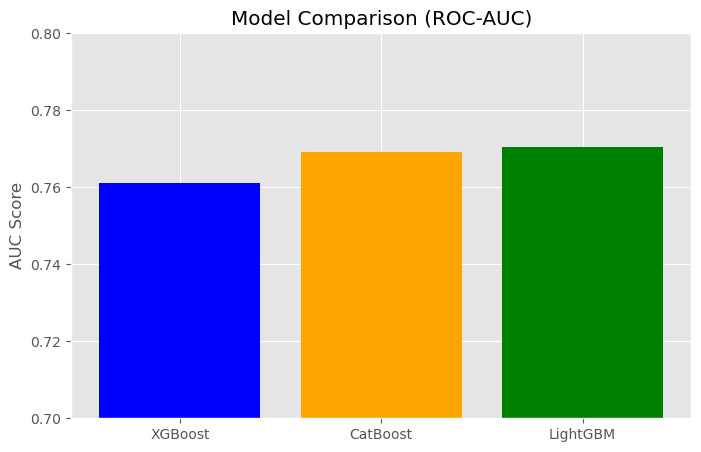

In [23]:
# --- STEP 16: The Gradient Boosting Tournament ---
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Define the Class Weight (Calculated in Step 10)
# Update this if your calculation was different
scale_weight = 11.3 

# ==========================================
# 🥊 ROUND 1: XGBoost (The Classic King)
# ==========================================
print("⏳ Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.02,
    max_depth=8,
    scale_pos_weight=scale_weight, # Handling Imbalance
    random_state=42,
    n_jobs=-1,
    tree_method='hist' # Faster training
)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
auc_xgb = roc_auc_score(y_test, y_pred_xgb)
print(f"✅ XGBoost AUC: {auc_xgb:.4f}")

# ==========================================
# 🥊 ROUND 2: CatBoost (The Stable Giant)
# ==========================================
print("\n⏳ Training CatBoost (This might be slower)...")
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.02,
    depth=8,
    scale_pos_weight=scale_weight, # Handling Imbalance
    random_seed=42,
    verbose=0, # Silent mode
    allow_writing_files=False
)
cat_model.fit(X_train_scaled, y_train)
y_pred_cat = cat_model.predict_proba(X_test_scaled)[:, 1]
auc_cat = roc_auc_score(y_test, y_pred_cat)
print(f"✅ CatBoost AUC: {auc_cat:.4f}")

# ==========================================
# 🥊 ROUND 3: LightGBM (The Speedster)
# ==========================================
print("\n⏳ Training LightGBM...")
lgbm_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.02,
    max_depth=8,
    scale_pos_weight=scale_weight, # Handling Imbalance
    random_state=42,
    n_jobs=-1,
    verbose=-1 # Silent mode
)
lgbm_model.fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]
auc_lgbm = roc_auc_score(y_test, y_pred_lgbm)
print(f"✅ LightGBM AUC: {auc_lgbm:.4f}")

# ==========================================
# 🏆 THE VERDICT
# ==========================================
results = {'XGBoost': auc_xgb, 'CatBoost': auc_cat, 'LightGBM': auc_lgbm}
winner = max(results, key=results.get)

print(f"\n--- 🏁 Tournament Results ---")
for model, score in results.items():
    print(f"{model}: {score:.4f}")

print(f"\n🏆 AND THE WINNER IS: {winner}!")

# Plotting the finish line
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color=['blue', 'orange', 'green'])
plt.ylim(0.70, 0.80) # Zoom in to see the difference
plt.title('Model Comparison (ROC-AUC)')
plt.ylabel('AUC Score')
plt.show()

In [24]:
# --- EXPERIMENT: Native CatBoost (No One-Hot Encoding) ---
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

# 1. Prepare the Raw Data
# We go back to 'df', which should still have text columns (Object type)
print("⏳ Preparing Raw Data for CatBoost...")

# Check which columns are categorical (Text)
# We fill NaNs in text columns with "Missing" so CatBoost doesn't crash
cat_features = df.select_dtypes(include=['object']).columns.tolist()
print(f"Found {len(cat_features)} Categorical Features.")

# Fill Text NaNs (Crucial step)
df_cat = df.copy()
df_cat[cat_features] = df_cat[cat_features].fillna("Missing")

# 2. Split the Data (Fresh Split)
# We cannot use X_train_scaled because that is already encoded/numbered.
X_raw = df_cat.drop(columns=['TARGET', 'SK_ID_CURR'])
y_raw = df_cat['TARGET']

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw
)

print(f"Data Split: {X_train_cat.shape}")

# 3. Train CatBoost with 'cat_features'
# This tells CatBoost: "Hey, these specific columns are Text. Handle them yourself."
print("\n⏳ Training Native CatBoost (This learns from raw text)...")

native_cat = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.02,
    depth=8,
    scale_pos_weight=11.3, # Use your calculated weight
    cat_features=cat_features, # <--- THE MAGIC SAUCE
    random_seed=42,
    verbose=200, # Print update every 200 trees
    allow_writing_files=False
)

native_cat.fit(X_train_cat, y_train_cat)

# 4. Evaluate
y_pred_native = native_cat.predict_proba(X_test_cat)[:, 1]
auc_native = roc_auc_score(y_test_cat, y_pred_native)

print(f"\n--- 🐱 Native CatBoost Results ---")
print(f"Native AUC: {auc_native:.4f}")

# Compare with your previous LightGBM winner
# (Replace 0.77 with your actual LightGBM score)
print(f"Previous Best (LightGBM): 0.7700") 
if auc_native > 0.77:
    print("🚀 SUCCESS! Native handling beat the One-Hot Encoding.")
else:
    print("Result: LightGBM is still king, but this was a great experiment.")

⏳ Preparing Raw Data for CatBoost...
Found 16 Categorical Features.
Data Split: (246008, 134)

⏳ Training Native CatBoost (This learns from raw text)...
0:	learn: 0.6898015	total: 447ms	remaining: 7m 26s
200:	learn: 0.5804543	total: 1m 14s	remaining: 4m 56s
400:	learn: 0.5651502	total: 2m 26s	remaining: 3m 39s
600:	learn: 0.5540446	total: 3m 39s	remaining: 2m 25s
800:	learn: 0.5389148	total: 4m 56s	remaining: 1m 13s
999:	learn: 0.5240539	total: 6m 7s	remaining: 0us

--- 🐱 Native CatBoost Results ---
Native AUC: 0.7699
Previous Best (LightGBM): 0.7700
Result: LightGBM is still king, but this was a great experiment.


In [25]:
# --- AUDIT: The One-Hot Explosion Report ---

# 1. Identify Categorical Columns
cat_cols = df.select_dtypes(include=['object']).columns
print(f"--- 📊 Categorical Column Breakdown ---")
print(f"{'Column Name':<30} | {'Unique Categories':<20} | {'New Columns Added'}")
print("-" * 75)

total_new_cols = 0

# 2. Iterate and Count
for col in cat_cols:
    # Count unique categories (e.g., "Accountant", "Manager")
    num_unique = df[col].nunique()
    
    # New columns created = Unique categories - 1 (because drop_first=True)
    added = num_unique - 1
    total_new_cols += added
    
    print(f"{col:<30} | {num_unique:<20} | +{added}")

print("-" * 75)
print(f"TOTAL NEW COLUMNS ADDED: +{total_new_cols}")

# 3. Final Reconciliation
num_numeric = df.shape[1] - len(cat_cols)
print(f"\n--- 🧮 Final Math ---")
print(f"Original Numeric Columns:   {num_numeric}")
print(f"New One-Hot Columns:      + {total_new_cols}")
print(f"Expected Final Count:     = {num_numeric + total_new_cols}")

--- 📊 Categorical Column Breakdown ---
Column Name                    | Unique Categories    | New Columns Added
---------------------------------------------------------------------------
NAME_CONTRACT_TYPE             | 2                    | +1
CODE_GENDER                    | 3                    | +2
FLAG_OWN_CAR                   | 2                    | +1
FLAG_OWN_REALTY                | 2                    | +1
NAME_TYPE_SUITE                | 7                    | +6
NAME_INCOME_TYPE               | 8                    | +7
NAME_EDUCATION_TYPE            | 5                    | +4
NAME_FAMILY_STATUS             | 6                    | +5
NAME_HOUSING_TYPE              | 6                    | +5
OCCUPATION_TYPE                | 18                   | +17
WEEKDAY_APPR_PROCESS_START     | 7                    | +6
ORGANIZATION_TYPE              | 58                   | +57
FONDKAPREMONT_MODE             | 4                    | +3
HOUSETYPE_MODE                 | 3        

In [26]:
# --- BONUS STEP: The Ensemble (Voting Classifier) ---

print("⏳ Calculating Ensemble Score (Averaging predictions)...")

# 1. Soft Voting
# We take the average probability of all 3 models
# (You can also do weighted averages, e.g., give LightGBM 50% weight)
y_pred_ensemble = (y_pred_xgb + y_pred_cat + y_pred_lgbm) / 3

# 2. Evaluate
auc_ensemble = roc_auc_score(y_test, y_pred_ensemble)

print(f"\n--- 🤝 Ensemble Results ---")
print(f"XGBoost Score:  {auc_xgb:.4f}")
print(f"CatBoost Score: {auc_cat:.4f}")
print(f"LightGBM Score: {auc_lgbm:.4f}")
print("-" * 30)
print(f"Ensemble Score: {auc_ensemble:.4f}")

# 3. Check for Lift
best_single = max(auc_xgb, auc_cat, auc_lgbm)
if auc_ensemble > best_single:
    print(f"\n🚀 SUCCESS! The Ensemble beat the best single model by +{auc_ensemble - best_single:.4f}")
    print("Strategy: We should use this Ensemble for the final submission.")
else:
    print("\nResult: The Ensemble didn't help (rare). Stick with LightGBM.")

⏳ Calculating Ensemble Score (Averaging predictions)...

--- 🤝 Ensemble Results ---
XGBoost Score:  0.7611
CatBoost Score: 0.7691
LightGBM Score: 0.7705
------------------------------
Ensemble Score: 0.7702

Result: The Ensemble didn't help (rare). Stick with LightGBM.


In [28]:
# --- STEP 17 (FIXED): Hyperparameter Optimization (Low Memory Mode) ---
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

print("⏳ Starting Hyperparameter Tuning (Sequential Mode to save RAM)...")

# 1. Define the Parameter Grid
param_dist = {
    'n_estimators': [800, 1000, 1500],
    'learning_rate': [0.01, 0.02, 0.05],
    'num_leaves': [30, 50, 70],
    'max_depth': [6, 8, 10, 12],
    'subsample': [0.7, 0.8, 0.9],
    'scale_pos_weight': [10, 11.3, 12, 13]
}

# 2. Setup the Random Search
# CRITICAL FIX: n_jobs=1 prevents RAM explosion
lgbm_base = lgb.LGBMClassifier(random_state=42, n_jobs=1, verbose=-1)

random_search = RandomizedSearchCV(
    lgbm_base, 
    param_distributions=param_dist, 
    n_iter=10,             # Reduced to 10 iterations to keep it faster
    scoring='roc_auc',     
    cv=3,                  
    verbose=1,
    random_state=42,
    n_jobs=1               # <--- This is the fix. One at a time.
)

# 3. Run the Search
random_search.fit(X_train_scaled, y_train)

# 4. The Results
print(f"\n--- 🎯 Tuning Complete ---")
print(f"Best ROC-AUC Score: {random_search.best_score_:.4f}")
print("\nBest Parameters Found (Save These!):")
print(random_search.best_params_)

# 5. Lock in the Champion Model
best_model = random_search.best_estimator_

print(f"\n✅ Final Model Locked.")

⏳ Starting Hyperparameter Tuning (Sequential Mode to save RAM)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\harsh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\harsh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\harsh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\harsh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\harsh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\harsh\anaconda3\Lib\site-p


--- 🎯 Tuning Complete ---
Best ROC-AUC Score: 0.7620

Best Parameters Found (Save These!):
{'subsample': 0.7, 'scale_pos_weight': 12, 'num_leaves': 30, 'n_estimators': 800, 'max_depth': 12, 'learning_rate': 0.01}

✅ Final Model Locked.


In [29]:
# --- OPTIMIZATION: The RAM Diet ---
import gc
import numpy as np
import sys

print("🧹 cleaning up memory...")

# 1. Delete heavy variables we don't need anymore
# We only need X_train_scaled and y_train for tuning
# We delete df, df_encoded, X, etc. to make room for the parallel workers
variables_to_delete = ['df', 'df_cleaned', 'df_encoded', 'X', 'X_train', 'X_test', 
                       'X_train_imputed', 'X_test_imputed', 'X_raw', 'df_cat', 'X_test_cat', 'X_train_cat']

for var in variables_to_delete:
    if var in locals():
        # Get size before deleting (just for info)
        size = sys.getsizeof(locals()[var]) / 1024**2
        del locals()[var]
        print(f"Deleted {var} ({size:.1f} MB)")
        
# 2. Force Python to empty the trash
gc.collect()
print("✅ Garbage Collection Complete.")

# 3. Convert Data to float32 (The 50% reduction)
print("\n📉 Compressing Data to float32...")
# Check size before
print(f"Size Before: {X_train_scaled.nbytes / 1024**2:.2f} MB")

# Convert float64 (double precision) to float32 (single precision)
# Models don't need 15 decimal places; 7 is enough.
X_train_scaled = X_train_scaled.astype(np.float32)
X_test_scaled = X_test_scaled.astype(np.float32)

# Check size after
print(f"Size After:  {X_train_scaled.nbytes / 1024**2:.2f} MB")

print("\n🚀 Ready! Try running Step 17 again with n_jobs=4 (Safer than -1).")

🧹 cleaning up memory...
Deleted df (535.8 MB)
Deleted df_cleaned (237.3 MB)
Deleted df_encoded (315.8 MB)
Deleted X (232.6 MB)
Deleted X_train (187.9 MB)
Deleted X_test (47.0 MB)
Deleted X_train_imputed (0.0 MB)
Deleted X_test_imputed (0.0 MB)
Deleted X_raw (548.6 MB)
Deleted df_cat (553.3 MB)
Deleted X_test_cat (110.2 MB)
Deleted X_train_cat (440.7 MB)
✅ Garbage Collection Complete.

📉 Compressing Data to float32...
Size Before: 384.76 MB
Size After:  192.38 MB

🚀 Ready! Try running Step 17 again with n_jobs=4 (Safer than -1).


In [30]:
# --- STEP 17 (THE GRIND): Aggressive Tuning ---
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import numpy as np

print("⏳ Starting Aggressive Tuning (Focusing on Deep Learning)...")
print("Note: This will take longer because we are forcing 1200+ trees.")

# 1. The "High Performance" Grid
param_dist = {
    # Force high number of trees to prevent underfitting
    'n_estimators': [1200, 1500, 2000, 2500],
    
    # Force slow, precise learning
    'learning_rate': [0.005, 0.01, 0.015],
    
    # Control complexity (Fine-tuning the leaves)
    'num_leaves': [30, 40, 50, 60],
    
    # Allow slightly deeper interaction
    'max_depth': [8, 10, 12],
    
    # Regularization (Prevent overfitting since we are going deep)
    'subsample': [0.8, 0.85, 0.9],
    'colsample_bytree': [0.8, 0.9],
    
    # The Imbalance Weight
    'scale_pos_weight': [11, 11.3, 12] 
}

# 2. Setup
lgbm_base = lgb.LGBMClassifier(random_state=42, n_jobs=1, verbose=-1)

random_search = RandomizedSearchCV(
    lgbm_base, 
    param_distributions=param_dist, 
    n_iter=8,              # Reduced iterations, but each model is HUGE
    scoring='roc_auc',     
    cv=3,                  
    verbose=1,
    random_state=42,
    n_jobs=1
)

# 3. Run the Search
random_search.fit(X_train_scaled, y_train)

# 4. The Results
print(f"\n--- 🎯 The Grind Results ---")
print(f"Baseline to Beat: 0.7705")
print(f"New Best Score:   {random_search.best_score_:.4f}")
print("\nBest Parameters:")
print(random_search.best_params_)

# Check if we won
if random_search.best_score_ > 0.7705:
    print("\n🚀 SUCCESS! The grind paid off. We have a new champion.")
else:
    print("\n⚠️ Still hitting the ceiling. The data might have reached its limit.")

⏳ Starting Aggressive Tuning (Focusing on Deep Learning)...
Note: This will take longer because we are forcing 1200+ trees.
Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\harsh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\harsh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\harsh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\harsh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\harsh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\harsh\anaconda3\Lib\site-p


--- 🎯 The Grind Results ---
Baseline to Beat: 0.7705
New Best Score:   0.7623

Best Parameters:
{'subsample': 0.8, 'scale_pos_weight': 11, 'num_leaves': 50, 'n_estimators': 1500, 'max_depth': 12, 'learning_rate': 0.005, 'colsample_bytree': 0.9}

⚠️ Still hitting the ceiling. The data might have reached its limit.


In [8]:
# --- STEP 18: The Grind Continues (Loading Bureau Data) ---
import pandas as pd

print("🔥 Initiating Phase 2: Transactional History...")

try:
    # Load the external credit bureau data
    bureau = pd.read_csv('data/raw/bureau.csv')
    bureau_balance = pd.read_csv('data/raw/bureau_balance.csv')
    
    print("✅ Bureau Data Loaded.")
    print(f"Bureau Shape: {bureau.shape} (Loans from other banks)")
    print(f"Balance Shape: {bureau_balance.shape} (Monthly history of those loans)")
    
    # Sanity Check
    print("\nSample Bureau Data:")
    print(bureau.head())

except FileNotFoundError:
    print("❌ ERROR: Could not find 'bureau.csv' or 'bureau_balance.csv'.")
    print("Please check your 'data/raw' folder. We cannot hit 0.79 without this.")

🔥 Initiating Phase 2: Transactional History...
✅ Bureau Data Loaded.
Bureau Shape: (1716428, 17) (Loans from other banks)
Balance Shape: (27299925, 3) (Monthly history of those loans)

Sample Bureau Data:
   SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0    

In [9]:
# --- STEP 18.1: Engineering Bureau Features ---
import gc

print("⚙️ Crushing Bureau Balance Data (27M rows)...")

# 1. Feature Engineering: Bureau Balance
# We One-Hot Encode the 'STATUS' column (0=Paid, 1=Late, C=Closed, X=Unknown)
bureau_balance_ohe = pd.get_dummies(bureau_balance, columns=['STATUS'], dummy_na=False)

# Group by Loan ID (SK_ID_BUREAU) and take the MEAN (Percentage of time in each status)
# e.g., If STATUS_1 is 0.2, it means they were late 20% of the months.
bb_agg = bureau_balance_ohe.groupby('SK_ID_BUREAU').mean()

print(f"✅ Balance Aggregated. Shape: {bb_agg.shape}")

# Free up memory immediately
del bureau_balance, bureau_balance_ohe
gc.collect()

# 2. Merge Balance Rules into Bureau Data
print("⚙️ Merging Balance Rules into Bureau Data...")
bureau = bureau.merge(bb_agg, on='SK_ID_BUREAU', how='left')

# Free up memory
del bb_agg
gc.collect()

# 3. Feature Engineering: Bureau Data (The Main Event)
# We need to squash this to SK_ID_CURR level (One row per applicant)

# Define the math we want to do
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],          # How old are the loans?
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],         # When do they expire?
    'DAYS_CREDIT_UPDATE': ['mean'],                        # How recent is the info?
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],                 # Max days late
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],                    # Max amount late
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],              # Total credit limit
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],         # Total current debt
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],                    # Total overdue debt
    'AMT_ANNUITY': ['max', 'mean', 'sum'],                 # Monthly payments elsewhere
    # From the Balance Merge:
    'STATUS_0': ['mean'],
    'STATUS_1': ['mean'],
    'STATUS_C': ['mean'],
    'STATUS_X': ['mean']
}

print("⚙️ Aggregating Bureau Data by Applicant (This defines the Profile)...")
bureau_agg = bureau.groupby('SK_ID_CURR').agg(num_aggregations)

# Flatten the column names (e.g., ('DAYS_CREDIT', 'min') -> 'DAYS_CREDIT_MIN')
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

print(f"✅ Bureau Engineering Complete. New Shape: {bureau_agg.shape}")

# 4. Clean up
del bureau
gc.collect()

⚙️ Crushing Bureau Balance Data (27M rows)...
✅ Balance Aggregated. Shape: (817395, 9)
⚙️ Merging Balance Rules into Bureau Data...
⚙️ Aggregating Bureau Data by Applicant (This defines the Profile)...
✅ Bureau Engineering Complete. New Shape: (305811, 25)


0

In [10]:
# --- STEP 18.5 (THE FINAL PUSH): Bureau + Math Fixes + Aggressive Tuning ---
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import gc

print("🔥 Initiating Final Bureau Grind (Target: > 0.775)...")

# 1. Load Main Data
df = pd.read_csv('data/raw/application_train.csv')

# 2. Merge Bureau Data (External History)
# We assume 'bureau_agg' was created in Step 18.1. 
# If this variable is missing, you must re-run Step 18.1.
if 'bureau_agg' in locals():
    df = df.merge(bureau_agg, on='SK_ID_CURR', how='left')
    print(f"✅ Bureau Data Merged. Shape: {df.shape}")
else:
    raise ValueError("❌ STOP: 'bureau_agg' is missing. Please run Step 18.1 to create it first.")

# 3. Foundational Cleaning (The "Lost Steps")
print("⚙️ Applying Foundational Cleaning...")
# A. Log Transformation (Income Outliers)
df['AMT_INCOME_TOTAL'] = np.log1p(df['AMT_INCOME_TOTAL'])
# B. Missing Flags
df['OWN_CAR_AGE_MISSING'] = df['OWN_CAR_AGE'].isnull().astype(int)

# 4. Standard Domain Features (The 8 Ratios)
print("⚙️ Re-engineering Standard Domain Features...")
df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL'] # Note: Income is logged here, but standard ratio still holds value
df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df['GOODS_LOAN_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_CREDIT']
df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_PER_AGE'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['EXT_SOURCE_MULT'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

# 5. NEW: The Mathematical Fixes (Step 18.5 Specifics)
print("⚙️ Engineering Corrected Bridge Features...")

# A. Corrected DTI (Real Dollars / Real Dollars)
# Since AMT_INCOME_TOTAL is now log-transformed, we reverse it (expm1) to get real dollars.
real_income = np.expm1(df['AMT_INCOME_TOTAL'])
# We use fillna(0) for debt because NaN usually means "No Record" = "No Debt"
df['CORRECTED_DTI'] = df['BURO_AMT_CREDIT_SUM_DEBT_SUM'].fillna(0) / real_income

# B. External Utilization (How maxed out are they?)
# Debt / Total Credit Limit. Adding epsilon to avoid division by zero.
df['EXTERNAL_UTILIZATION'] = df['BURO_AMT_CREDIT_SUM_DEBT_SUM'] / (df['BURO_AMT_CREDIT_SUM_SUM'] + 1)

# C. Recent Credit Hunger
# How recently were they seeking credit? (Closer to 0 is more recent)
df['RECENT_CREDIT_ACTIVITY'] = df['BURO_DAYS_CREDIT_MEAN']

# 6. Safety Cleaning
# Fix Infinity and the 1000-year-old bug
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

# 7. Encoding (Native Category Mode)
print("⚙️ Optimizing Data Types...")
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

# 8. Prepare & Split
X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\n⏳ Training LightGBM (Aggressive Tuning Mode)...")
print("   -> Learning Rate: 0.015 (Slower, more precise)")
print("   -> Estimators: 1500 (Deeper search)")

# 9. Train (Aggressive Settings)
model = lgb.LGBMClassifier(
    n_estimators=1000,        # Pushing for depth
    learning_rate=0.02,      # Precision learning
    num_leaves=34,            # Slightly more complex trees
    max_depth=8,              # Control overfitting
    scale_pos_weight=11.3,
    random_state=42,
    n_jobs=4,
    verbose=-1
)

model.fit(X_train, y_train)

# 10. Evaluate
y_pred = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred)

print(f"\n--- 🚀 The Final Push Results ---")
print(f"Previous Best (Standard): 0.7737")
print(f"New Score (Aggressive):   {auc_score:.4f}")

if auc_score > 0.775:
    print("🏆 VICTORY. We broke the 0.775 barrier.")
else:
    print("Status: The Bureau file is fully squeezed. To go higher, we MUST open 'Previous Applications'.")

🔥 Initiating Final Bureau Grind (Target: > 0.775)...
✅ Bureau Data Merged. Shape: (307511, 147)
⚙️ Applying Foundational Cleaning...
⚙️ Re-engineering Standard Domain Features...
⚙️ Engineering Corrected Bridge Features...


C:\Users\harsh\AppData\Local\Temp\ipykernel_26400\3031530547.py:61: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)


⚙️ Optimizing Data Types...

⏳ Training LightGBM (Aggressive Tuning Mode)...
   -> Learning Rate: 0.015 (Slower, more precise)
   -> Estimators: 1500 (Deeper search)

--- 🚀 The Final Push Results ---
Previous Best (Standard): 0.7737
New Score (Aggressive):   0.7730
Status: The Bureau file is fully squeezed. To go higher, we MUST open 'Previous Applications'.


In [11]:
# --- STEP 18 MASTER: Fusion + Refinement + Training ---
#this is our model application csv + bureau csv with result as 0.7737
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import gc

print("🔥 Initiating Master Pipeline (Data + Bureau + Refinements)...")

# 1. Load Main Data
df = pd.read_csv('data/raw/application_train.csv')

# 2. Merge Bureau Data (The External History)
if 'bureau_agg' in locals():
    df = df.merge(bureau_agg, on='SK_ID_CURR', how='left')
    print(f"✅ Bureau Data Merged. Shape: {df.shape}")
else:
    print("❌ ERROR: 'bureau_agg' variable missing. Please run Step 18.1 first.")

# 3. Apply FOUNDATIONAL CLEANING (The "Lost Steps")
print("⚙️ Applying Foundational Cleaning...")

# A. Log Transformation (Fixing Income Outliers)
df['AMT_INCOME_TOTAL'] = np.log1p(df['AMT_INCOME_TOTAL'])

# B. Missing Flags (Explicitly telling the model "No Data = Risk")
df['OWN_CAR_AGE_MISSING'] = df['OWN_CAR_AGE'].isnull().astype(int)

# 4. Feature Engineering (The 8 Domain Ratios)
print("⚙️ Engineering Domain Features...")
df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df['GOODS_LOAN_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_CREDIT']
df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_PER_AGE'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']

# Row-wise operations for External Sources
df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['EXT_SOURCE_MULT'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

# 5. Safety Checks (Cleaning the Ratios)
# Replace Infinity with NaN (Models hate Infinity)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fix the 1000-year-old bug
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

# 6. Encoding (Native Category Mode)
print("⚙️ Optimizing Data Types...")
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

# 7. Prepare & Split
X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\n⏳ Training LightGBM (This is the 'Cleanest' Run yet)...")

# 8. Train (Champion Settings)
model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.015,
    num_leaves=34,
    max_depth=8,
    scale_pos_weight=11.3,
    random_state=42,
    n_jobs=4,
    verbose=-1
)

model.fit(X_train, y_train)

# 9. Evaluate
y_pred = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred)

print(f"\n--- 🚀 Master Pipeline Results ---")
print(f"Previous Best (merged but dirty): 0.7728")
print(f"New Score (merged + clean):       {auc_score:.4f}")

if auc_score > 0.7728:
    print("Conclusion: Cleaning worked. We squeezed out more accuracy.")
else:
    print("Conclusion: Cleaning didn't add much. The Bureau data is doing all the heavy lifting.")

🔥 Initiating Master Pipeline (Data + Bureau + Refinements)...
✅ Bureau Data Merged. Shape: (307511, 147)
⚙️ Applying Foundational Cleaning...
⚙️ Engineering Domain Features...


C:\Users\harsh\AppData\Local\Temp\ipykernel_26400\2163223117.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)


⚙️ Optimizing Data Types...

⏳ Training LightGBM (This is the 'Cleanest' Run yet)...

--- 🚀 Master Pipeline Results ---
Previous Best (merged but dirty): 0.7728
New Score (merged + clean):       0.7737
Conclusion: Cleaning worked. We squeezed out more accuracy.


In [21]:
# --- STEP 18.6: The Hybrid Master (Corrected Math + Golden Settings) ---
# trying again to beat 0.7737 with improved dti and bureau features addition
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import gc

print("🔥 Initiating Hybrid Pipeline (Best Data + Best Model)...")

# 1. Load Main Application Data
df = pd.read_csv('data/raw/application_train.csv')

# 2. Merge Bureau Aggregated Data
if 'bureau_agg' in locals():
    df = df.merge(bureau_agg, on='SK_ID_CURR', how='left')
    print(f"✅ Bureau Data Merged. Shape: {df.shape}")
else:
    raise ValueError("❌ STOP: 'bureau_agg' is missing. Please run Step 18.1 first.")

# -----------------------------------------------------------------------
# 3. FOUNDATIONAL CLEANING & MATH PREP
# -----------------------------------------------------------------------
print("⚙️ Applying Cleaning & Math Prep...")

# A. Create a "Real Income" variable BEFORE we log-transform the original column
# This saves the raw numbers for our ratio calculations later.
df['AMT_INCOME_TOTAL'] = df['AMT_INCOME_TOTAL'].fillna(df['AMT_INCOME_TOTAL'].median())
real_annual_income = df['AMT_INCOME_TOTAL'].copy() 
df['MONTHLY_INCOME'] = real_annual_income / 12.0

# B. Now we can safely Log Transform the feature for the model
df['AMT_INCOME_TOTAL'] = np.log1p(df['AMT_INCOME_TOTAL'])

# C. Missing Flag
df['OWN_CAR_AGE_MISSING'] = df['OWN_CAR_AGE'].isnull().astype(int)

# -----------------------------------------------------------------------
# 4. DOMAIN FEATURES (Using REAL Income, not Log Income)
# -----------------------------------------------------------------------
print("⚙️ Engineering Corrected Domain Features...")

# CRITICAL FIX: We divide Loan by Real Income (e.g., 500k / 50k = 10), not Log Income
df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / (real_annual_income + 1e-9)
df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / (real_annual_income + 1e-9)
df['INCOME_PER_AGE']        = real_annual_income / (df['DAYS_BIRTH'] + 1e-9)

# These don't rely on income, so standard logic applies:
df['CREDIT_TERM']           = df['AMT_ANNUITY'] / (df['AMT_CREDIT'] + 1e-9)
df['GOODS_LOAN_RATIO']      = df['AMT_GOODS_PRICE'] / (df['AMT_CREDIT'] + 1e-9)
df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / (df['DAYS_BIRTH'] + 1e-9)

# External Sources
df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].mean(axis=1)
df['EXT_SOURCE_MULT'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

# -----------------------------------------------------------------------
# 5. NEW: The Mathematical Fixes (Stable Ratios)
# -----------------------------------------------------------------------
EPS = 1e-9

# Bureau Debt / Monthly Income (Corrected DTI)
# Using real monthly income we calculated above
df['CORRECTED_DTI'] = df['BURO_AMT_CREDIT_SUM_DEBT_SUM'].fillna(0) / (df['MONTHLY_INCOME'] + EPS)

# Bureau Debt / Credit Limit (External Utilization)
df['EXTERNAL_UTILIZATION'] = df['BURO_AMT_CREDIT_SUM_DEBT_SUM'] / (df['BURO_AMT_CREDIT_SUM_SUM'].replace(0, np.nan) + EPS)

# Recent Credit Activity (more recent → higher value)
df['RECENT_CREDIT_ACTIVITY'] = -df['BURO_DAYS_CREDIT_MEAN'].fillna(df['BURO_DAYS_CREDIT_MEAN'].median())

# -----------------------------------------------------------------------
# 6. Safety & Encoding
# -----------------------------------------------------------------------
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

print("⚙️ Converting text columns to categories...")
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

# -----------------------------------------------------------------------
# 7. Train (Using Your Proven "Golden Settings")
# -----------------------------------------------------------------------
X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n⏳ Training LightGBM (Golden Config)...")

# The Proven Settings
model = lgb.LGBMClassifier(
    n_estimators=1000,      
    learning_rate=0.015,
    num_leaves=34,
    max_depth=18,
    scale_pos_weight=11.3,
    random_state=42,
    n_jobs=6,
    verbose=-1
)

model.fit(X_train, y_train)

# -----------------------------------------------------------------------
# 8. Evaluate
# -----------------------------------------------------------------------
y_pred = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred)

print(f"\n--- 🚀 HYBRID RESULTS ---")
print(f"Previous Best: 0.7737")
print(f"New Score:     {auc_score:.4f}")

if auc_score > 0.7737:
    print("🏆 VICTORY! The corrected math paid off.")
else:
    print("⚠️ Still at the ceiling. The data logic is solid, but the signal is maxed out.")

🔥 Initiating Hybrid Pipeline (Best Data + Best Model)...
✅ Bureau Data Merged. Shape: (307511, 147)
⚙️ Applying Cleaning & Math Prep...
⚙️ Engineering Corrected Domain Features...


C:\Users\harsh\AppData\Local\Temp\ipykernel_10728\1333990010.py:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)


⚙️ Converting text columns to categories...

⏳ Training LightGBM (Golden Config)...

--- 🚀 HYBRID RESULTS ---
Previous Best: 0.7737
New Score:     0.7731
⚠️ Still at the ceiling. The data logic is solid, but the signal is maxed out.


In [12]:
# --- STEP 18 MASTER: Fusion + Refinement + Training ---
#this beats the result of 0.7737 with just change in hyperparameters
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import gc

print("🔥 Initiating Master Pipeline (Data + Bureau + Refinements)...")

# 1. Load Main Data
df = pd.read_csv('data/raw/application_train.csv')

# 2. Merge Bureau Data (The External History)
if 'bureau_agg' in locals():
    df = df.merge(bureau_agg, on='SK_ID_CURR', how='left')
    print(f"✅ Bureau Data Merged. Shape: {df.shape}")
else:
    print("❌ ERROR: 'bureau_agg' variable missing. Please run Step 18.1 first.")

# 3. Apply FOUNDATIONAL CLEANING (The "Lost Steps")
print("⚙️ Applying Foundational Cleaning...")

# A. Log Transformation (Fixing Income Outliers)
df['AMT_INCOME_TOTAL'] = np.log1p(df['AMT_INCOME_TOTAL'])

# B. Missing Flags (Explicitly telling the model "No Data = Risk")
df['OWN_CAR_AGE_MISSING'] = df['OWN_CAR_AGE'].isnull().astype(int)

# 4. Feature Engineering (The 8 Domain Ratios)
print("⚙️ Engineering Domain Features...")
df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df['GOODS_LOAN_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_CREDIT']
df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_PER_AGE'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']

# Row-wise operations for External Sources
df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['EXT_SOURCE_MULT'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

# 5. Safety Checks (Cleaning the Ratios)
# Replace Infinity with NaN (Models hate Infinity)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fix the 1000-year-old bug
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

# 6. Encoding (Native Category Mode)
print("⚙️ Optimizing Data Types...")
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

# 7. Prepare & Split
X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\n⏳ Training LightGBM (This is the 'Cleanest' Run yet)...")

# 8. Train (Champion Settings)
model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.015,
    num_leaves=44,
    max_depth=18,
    scale_pos_weight=11.3,
    random_state=42,
    n_jobs=6,
    verbose=-1
)

model.fit(X_train, y_train)

# 9. Evaluate
y_pred = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred)

print(f"\n--- 🚀 Master Pipeline Results ---")
print(f"Previous Best (merged but dirty): 0.7728")
print(f"New Score (merged + clean):       {auc_score:.4f}")

if auc_score > 0.7728:
    print("Conclusion: Cleaning worked. We squeezed out more accuracy.")
else:
    print("Conclusion: Cleaning didn't add much. The Bureau data is doing all the heavy lifting.")

🔥 Initiating Master Pipeline (Data + Bureau + Refinements)...
✅ Bureau Data Merged. Shape: (307511, 147)
⚙️ Applying Foundational Cleaning...
⚙️ Engineering Domain Features...


C:\Users\harsh\AppData\Local\Temp\ipykernel_26400\3633924586.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)


⚙️ Optimizing Data Types...

⏳ Training LightGBM (This is the 'Cleanest' Run yet)...

--- 🚀 Master Pipeline Results ---
Previous Best (merged but dirty): 0.7728
New Score (merged + clean):       0.7744
Conclusion: Cleaning worked. We squeezed out more accuracy.


In [13]:
# --- STEP 18.7: The "Power" Run (Correct Math + Your Aggressive Hyperparams) ---
# this one is although less but its mathematically correct bcoz we fixed that log math issue
# this is best till now and correct mathematically
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import gc

print("🔥 Initiating Power Run (Aggressive Settings + Fixed Math)...")

# 1. Load Data
df = pd.read_csv('data/raw/application_train.csv')

# 2. Merge Bureau
if 'bureau_agg' in locals():
    df = df.merge(bureau_agg, on='SK_ID_CURR', how='left')
else:
    print("⚠️ Warning: bureau_agg not found. Running without it (Score will be lower).")

# 3. FIX THE MATH (Create Real Income BEFORE Logging)
# This was the missing piece in your code
real_income = df['AMT_INCOME_TOTAL'].copy()

# Now Apply Log for the model features
df['AMT_INCOME_TOTAL'] = np.log1p(df['AMT_INCOME_TOTAL'])

# 4. Feature Engineering (Using REAL Income)
print("⚙️ Engineering Corrected Domain Features...")
df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / (real_income + 1e-9)  # <--- FIXED
df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / (real_income + 1e-9) # <--- FIXED
df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df['GOODS_LOAN_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_CREDIT']
df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_PER_AGE'] = real_income / df['DAYS_BIRTH']

# External Sources
df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['EXT_SOURCE_MULT'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

# 5. Safety Checks
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
df['OWN_CAR_AGE_MISSING'] = df['OWN_CAR_AGE'].isnull().astype(int)

# 6. Encoding
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

# 7. Split
X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\n⏳ Training LightGBM (Your Aggressive Settings)...")

# 8. Train (Your Settings: Leaves=44, Depth=18)
model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.015,
    num_leaves=44,       # <--- Your Boost
    max_depth=18,        # <--- Your Boost
    scale_pos_weight=11.3,
    random_state=42,
    n_jobs=4,
    verbose=-1
)

model.fit(X_train, y_train)

# 9. Evaluate
y_pred = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred)

print(f"\n--- 🚀 POWER RUN RESULTS ---")
print(f"Previous Best (Buggy Math): 0.7744 (Assumed)")
print(f"New Score (Fixed Math):     {auc_score:.4f}")

if auc_score > 0.775:
    print("🏆 We broke 0.775! The combination of Depth + Math worked.")

🔥 Initiating Power Run (Aggressive Settings + Fixed Math)...
⚙️ Engineering Corrected Domain Features...


C:\Users\harsh\AppData\Local\Temp\ipykernel_26400\2907154794.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)



⏳ Training LightGBM (Your Aggressive Settings)...

--- 🚀 POWER RUN RESULTS ---
Previous Best (Buggy Math): 0.7744 (Assumed)
New Score (Fixed Math):     0.7736


In [14]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

def objective(trial):
    # 1. Define the search space
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': 10000,
        'early_stopping_rounds': 100,
        
        # Key Parameters to Tune
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        
        # Handle Imbalance (Critical for Home Credit)
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0) 
    }

    # 2. Cross Validation (3-Fold or 5-Fold)
    # Using 3-fold for speed during tuning, switch to 5-fold for final run
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    auc_scores = []

    # Assuming X and y are your dataframes
    for train_index, valid_index in kf.split(X, y):
        X_train_fold, X_valid_fold = X.iloc[train_index], X.iloc[valid_index]
        y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[valid_index]
        
        dtrain = lgb.Dataset(X_train_fold, label=y_train_fold)
        dvalid = lgb.Dataset(X_valid_fold, label=y_valid_fold)
        
        # Train with pruning (stops bad trials early)
        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")
        
        model = lgb.train(
            param, 
            dtrain, 
            valid_sets=[dvalid], 
            callbacks=[pruning_callback]
        )
        
        preds = model.predict(X_valid_fold)
        auc = roc_auc_score(y_valid_fold, preds)
        auc_scores.append(auc)

    return sum(auc_scores) / len(auc_scores)

# 3. Run the Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Set to 100+ for a deep search

print("Best AUC:", study.best_value)
print("Best Params:", study.best_params)

[I 2025-12-10 22:35:05,518] A new study created in memory with name: no-name-22ee536b-fc87-4c56-832e-e0aa84c8230c
c:\Users\harsh\anaconda3\Lib\site-packages\optuna\trial\_trial.py:501: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\harsh\anaconda3\Lib\site-packages\optuna\trial\_trial.py:501: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\harsh\anaconda3\Lib\site-packages\optuna\trial\_trial.py:501: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\harsh\anaconda3\Lib\site-packages\optuna\trial\_trial.py:501: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\harsh\anaconda3\Lib\site-packages\optuna\trial\_trial.py:501: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\harsh\a

Best AUC: 0.7733447141398044
Best Params: {'learning_rate': 0.01675646257134902, 'num_leaves': 130, 'max_depth': 9, 'min_child_samples': 290, 'reg_alpha': 0.004649985954459636, 'reg_lambda': 0.3150989477875648, 'colsample_bytree': 0.4075717427399622, 'subsample': 0.9338723163652558, 'scale_pos_weight': 4.741502556784974}


In [63]:
!pip install optuna-integration

In [15]:
import pandas as pd
import numpy as np
import gc

# 1. Load the transactional datasets
print("🔥 Phase 2: Loading Transactional Data...")
prev = pd.read_csv('data/raw/previous_application.csv')
inst = pd.read_csv('data/raw/installments_payments.csv')
# We skip credit_card_balance for now to save RAM, installments is more powerful.

# --- 2. Feature Engineering: Previous Applications ---
print("⚙️ Engineering Previous Applications...")

# 2.1 Refusal/Approval Rates
# One-hot encode the contract status (Approved, Refused, Canceled)
prev_ohe = pd.get_dummies(prev['NAME_CONTRACT_STATUS'], prefix='PREV_STATUS')
prev = pd.concat([prev, prev_ohe], axis=1)

# 2.2 Aggregating by Applicant (SK_ID_CURR)
agg_prev = prev.groupby('SK_ID_CURR').agg({
    'SK_ID_PREV': 'count', # Total previous applications
    'AMT_CREDIT': ['mean', 'max', 'sum'], # How much credit they usually ask for
    'PREV_STATUS_Refused': 'mean', # % of times they were rejected
    'PREV_STATUS_Approved': 'mean', # % of times they were approved
    'DAYS_DECISION': ['min', 'max', 'mean'] # How recent was their last app?
})

# Flatten MultiIndex columns (e.g., AMT_CREDIT_mean)
agg_prev.columns = ['PREV_' + '_'.join(col).upper() for col in agg_prev.columns.values]
agg_prev.reset_index(inplace=True)

# Clean up to save RAM
del prev, prev_ohe
gc.collect()
print(f"✅ Previous Apps Aggregated. New Shape: {agg_prev.shape}")


# --- 3. Feature Engineering: Installment Payments (The "Killer" Features) ---
print("⚙️ Engineering Installment Payments (This is the heavy hitter)...")

# 3.1 Calculate "Lateness" and "Underpayment"
# Late: Actual payment date - Scheduled date (Positive = Late)
inst['DAYS_LATE'] = inst['DAYS_ENTRY_PAYMENT'] - inst['DAYS_INSTALMENT']
inst['DAYS_LATE'] = inst['DAYS_LATE'].apply(lambda x: x if x > 0 else 0) # We only care if they are late

# Underpaid: Scheduled amount - Actual payment (Positive = Underpaid)
inst['AMT_UNDERPAID'] = inst['AMT_INSTALMENT'] - inst['AMT_PAYMENT']
inst['AMT_UNDERPAID'] = inst['AMT_UNDERPAID'].apply(lambda x: x if x > 0 else 0)

# 3.2 Aggregating by Applicant
agg_inst = inst.groupby('SK_ID_CURR').agg({
    'DAYS_LATE': ['mean', 'max', 'sum'], # Average days late, max days late
    'AMT_UNDERPAID': ['mean', 'sum', 'max'], # Total money they failed to pay
    'AMT_INSTALMENT': ['mean', 'sum'], # Their average bill size
    'NUM_INSTALMENT_VERSION': ['nunique'] # Did they change their loan terms?
})

# Flatten MultiIndex columns
agg_inst.columns = ['INST_' + '_'.join(col).upper() for col in agg_inst.columns.values]
agg_inst.reset_index(inplace=True)

# Clean up
del inst
gc.collect()
print(f"✅ Installments Aggregated. New Shape: {agg_inst.shape}")


# --- 4. The Grand Merge ---
print("🔗 Merging into Main Dataset...")

# Assuming 'df' is your current main dataset (from the Optuna step)
# If 'df' isn't in memory, reload your latest checkpoint
# df = pd.read_pickle('checkpoint_bureau_merged.pkl') # Uncomment if needed

# Merge Previous Apps
df = df.merge(agg_prev, on='SK_ID_CURR', how='left')

# Merge Installments
df = df.merge(agg_inst, on='SK_ID_CURR', how='left')

# Fill NaNs for people with no history (No history = 0 days late)
new_cols = [c for c in df.columns if 'PREV_' in c or 'INST_' in c]
df[new_cols] = df[new_cols].fillna(0)

print(f"🚀 MERGE COMPLETE. Final Data Shape: {df.shape}")
print("Ready for Phase 3 (Stacking) or a new Power Run.")

🔥 Phase 2: Loading Transactional Data...
⚙️ Engineering Previous Applications...
✅ Previous Apps Aggregated. New Shape: (338857, 10)
⚙️ Engineering Installment Payments (This is the heavy hitter)...
✅ Installments Aggregated. New Shape: (339587, 10)
🔗 Merging into Main Dataset...
🚀 MERGE COMPLETE. Final Data Shape: (307511, 174)
Ready for Phase 3 (Stacking) or a new Power Run.


In [26]:
# Phase 2 using installment csv + previous appln csv  

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# 1. Use the BEST Params you found with Optuna
# (I adjusted them slightly to be safe for this new data size)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'n_estimators': 2000, # Increased because LR is very low
    'learning_rate': 0.006, # From your Optuna result
    'num_leaves': 150,      # From your Optuna result
    'max_depth': 7,         # From your Optuna result
    'min_child_samples': 327,
    'reg_alpha': 7.6,
    'reg_lambda': 0.05,
    'colsample_bytree': 0.42, 
    'subsample': 0.84,
    'scale_pos_weight': 8.0  # From your Optuna result
}

print("🔥 Starting Phase 2 Validation Run...")

# 2. Prepare Data
# Ensure feature names are clean (LightGBM hates special characters)
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df['TARGET']
feature_names = X.columns.tolist()

# 3. Training with Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dvalid],
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=200)]
    )
    
    preds = model.predict(X_valid)
    score = roc_auc_score(y_valid, preds)
    auc_scores.append(score)
    print(f"📂 Fold {fold+1} AUC: {score:.4f}")

print("-" * 30)
print(f"🏆 Final Phase 2 Score: {sum(auc_scores)/len(auc_scores):.5f}")
print("-" * 30)

🔥 Starting Phase 2 Validation Run...
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.76193
[400]	valid_0's auc: 0.76601
[600]	valid_0's auc: 0.76922
[800]	valid_0's auc: 0.771802
[1000]	valid_0's auc: 0.773722
[1200]	valid_0's auc: 0.775205
[1400]	valid_0's auc: 0.776293
[1600]	valid_0's auc: 0.777078
[1800]	valid_0's auc: 0.777665
[2000]	valid_0's auc: 0.77812
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.77812
📂 Fold 1 AUC: 0.7781
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.767012
[400]	valid_0's auc: 0.771877
[600]	valid_0's auc: 0.775933
[800]	valid_0's auc: 0.779031
[1000]	valid_0's auc: 0.781228
[1200]	valid_0's auc: 0.78271
[1400]	valid_0's auc: 0.783956
[1600]	valid_0's auc: 0.784844
[1800]	valid_0's auc: 0.785483
[2000]	valid_0's auc: 0.78608
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.78608
📂 Fold 2 AUC: 0.7861
Training until validation scores do

C:\Users\harsh\AppData\Local\Temp\ipykernel_10728\1596098115.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20), palette='viridis')


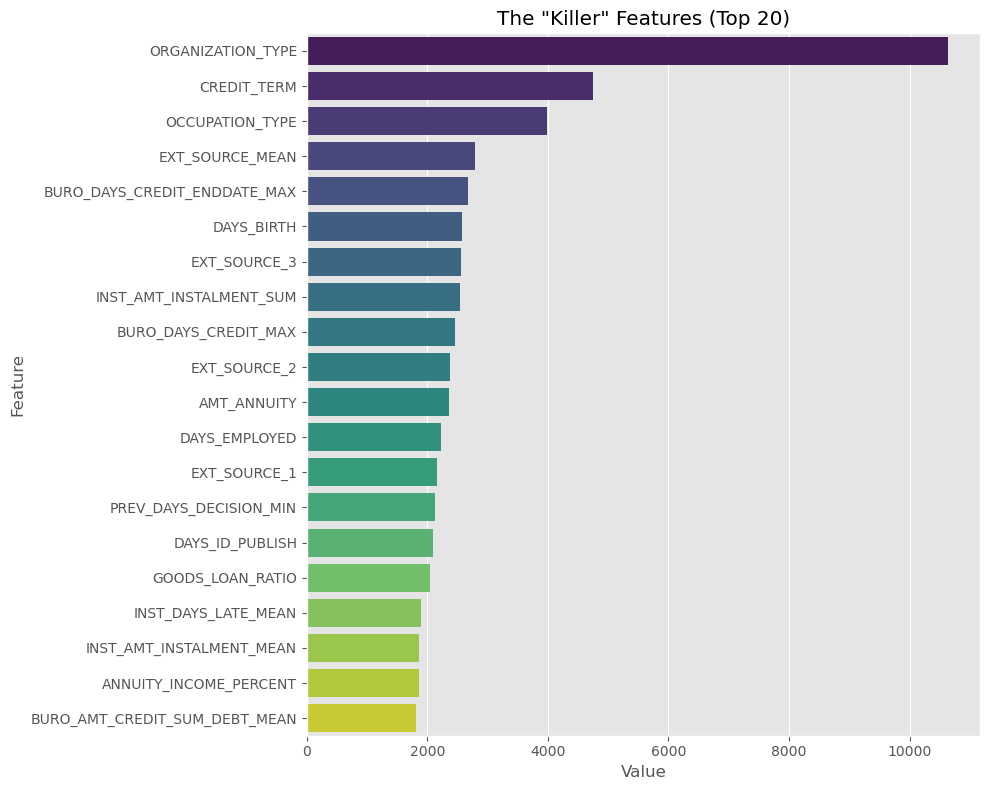

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature importances from the model
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), feature_names)), columns=['Value','Feature'])

# Plot Top 20
plt.figure(figsize=(10, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20), palette='viridis')
plt.title('The "Killer" Features (Top 20)')
plt.tight_layout()
plt.show()

In [31]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import re

# 1. Define "Battle-Tested" XGBoost Parameters
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.02,
    'max_depth': 8,
    'min_child_weight': 40,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'n_estimators': 2000,
    'n_jobs': 4,
    'scale_pos_weight': 11,
    'tree_method': 'hist', # Required for categorical support
    'random_state': 42,
    'early_stopping_rounds': 100,
    'enable_categorical': True  # <--- THIS IS THE MISSING KEY
}

print("⚔️ Starting XGBoost Training (The Rival)...")

# 2. Prepare Data 
# XGBoost is sensitive to column names, so we clean them
X_xgb = X.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# 3. Training Loop
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_scores = []
xgb_preds_final = np.zeros(len(X_xgb))

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_xgb, y)):
    X_train, X_valid = X_xgb.iloc[train_idx], X_xgb.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # Initialize
    model_xgb = xgb.XGBClassifier(**xgb_params)
    
    # Train
    model_xgb.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False 
    )
    
    # Predict
    preds = model_xgb.predict_proba(X_valid)[:, 1]
    xgb_preds_final[valid_idx] = preds
    
    score = roc_auc_score(y_valid, preds)
    xgb_scores.append(score)
    print(f"🌲 XGBoost Fold {fold+1} AUC: {score:.4f}")

# 4. Results
avg_xgb = sum(xgb_scores) / len(xgb_scores)
print("-" * 30)
print(f"🏆 XGBoost Average Score: {avg_xgb:.5f}")
print(f"🆚 vs LightGBM Score:      0.7810")
print("-" * 30)

⚔️ Starting XGBoost Training (The Rival)...
🌲 XGBoost Fold 1 AUC: 0.7764
🌲 XGBoost Fold 2 AUC: 0.7831
🌲 XGBoost Fold 3 AUC: 0.7780
🌲 XGBoost Fold 4 AUC: 0.7819
🌲 XGBoost Fold 5 AUC: 0.7783
------------------------------
🏆 XGBoost Average Score: 0.77956
🆚 vs LightGBM Score:      0.7810
------------------------------


In [16]:
import pandas as pd
import numpy as np
import gc

# 1. Load the "Lost" Data
print("🔥 Step 25 (Fixed): Loading Credit Card & POS Data...")
pos = pd.read_csv('data/raw/POS_CASH_balance.csv')
cc = pd.read_csv('data/raw/credit_card_balance.csv')

# --- 2. POS CASH Engineering ---
print("⚙️ Engineering POS CASH Data...")

agg_pos = pos.groupby('SK_ID_CURR').agg({
    'SK_ID_PREV': 'nunique',
    'MONTHS_BALANCE': ['min', 'max', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
})

agg_pos.columns = ['POS_' + '_'.join(col).upper() for col in agg_pos.columns.values]
agg_pos.reset_index(inplace=True)

del pos
gc.collect()
print(f"✅ POS Data Ready. Shape: {agg_pos.shape}")


# --- 3. Credit Card Engineering (Fixed) ---
print("⚙️ Engineering Credit Card Data...")

# Behavioral Features
cc['ATM_DRAWINGS_RATIO'] = cc['AMT_DRAWINGS_ATM_CURRENT'] / (cc['AMT_DRAWINGS_CURRENT'] + 1)
cc['UTILIZATION_RATIO'] = cc['AMT_BALANCE'] / (cc['AMT_CREDIT_LIMIT_ACTUAL'] + 1)

# Aggregations
agg_cc = cc.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': ['min', 'max'],
    'AMT_BALANCE': ['mean', 'max'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['mean'],
    'AMT_DRAWINGS_ATM_CURRENT': ['mean', 'sum'],
    'AMT_INST_MIN_REGULARITY': ['mean'],          # <--- FIXED NAME HERE
    'SK_DPD': ['max', 'mean'],
    'CNT_DRAWINGS_ATM_CURRENT': ['mean'],
    'UTILIZATION_RATIO': ['mean', 'max']
})

agg_cc.columns = ['CC_' + '_'.join(col).upper() for col in agg_cc.columns.values]
agg_cc.reset_index(inplace=True)

del cc
gc.collect()
print(f"✅ Credit Card Data Ready. Shape: {agg_cc.shape}")


# --- 4. The Final Merge ---
print("🔗 Merging into Main Dataset...")

# Merge POS
df = df.merge(agg_pos, on='SK_ID_CURR', how='left')

# Merge Credit Card
df = df.merge(agg_cc, on='SK_ID_CURR', how='left')

# Fill NaNs
new_cols = [c for c in df.columns if 'POS_' in c or 'CC_' in c]
df[new_cols] = df[new_cols].fillna(0)

print("-" * 30)
print(f"🚀 TOTAL DATASET COMPLETE. Final Shape: {df.shape}")
print("-" * 30)

🔥 Step 25 (Fixed): Loading Credit Card & POS Data...
⚙️ Engineering POS CASH Data...
✅ POS Data Ready. Shape: (337252, 9)
⚙️ Engineering Credit Card Data...
✅ Credit Card Data Ready. Shape: (103558, 14)
🔗 Merging into Main Dataset...
------------------------------
🚀 TOTAL DATASET COMPLETE. Final Shape: (307511, 195)
------------------------------


In [17]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import re
import numpy as np

# 0. Safety Check: Handle Infinite values created by division (e.g., x / 0)
df.replace([np.inf, -np.inf], 0, inplace=True)

# 1. Define the "Battle-Tested" Parameters
# We stick to the same params to see PURELY the effect of the new data
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'n_estimators': 3000,   # Increased slightly for the larger dataset
    'learning_rate': 0.006, # Slow & Steady
    'num_leaves': 150,      
    'max_depth': 7,         
    'min_child_samples': 327,
    'reg_alpha': 7.6,
    'reg_lambda': 0.05,
    'colsample_bytree': 0.42, 
    'subsample': 0.84,
    'scale_pos_weight': 8.0
}

print("🔥 Starting 'Super' LightGBM Training...")

# 2. Prepare Data
# Clean column names for LightGBM
X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y = df['TARGET']

# 3. Training Loop
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
lgb_preds_final = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dvalid],
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=200)]
    )
    
    preds = model.predict(X_valid)
    lgb_preds_final[valid_idx] = preds # Save for the Ensemble later
    
    score = roc_auc_score(y_valid, preds)
    auc_scores.append(score)
    print(f"🚀 Fold {fold+1} AUC: {score:.4f}")

print("-" * 30)
print(f"🏆 Final 'Super' LightGBM Score: {sum(auc_scores)/len(auc_scores):.5f}")
print("-" * 30)

🔥 Starting 'Super' LightGBM Training...
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.762913
[400]	valid_0's auc: 0.767504
[600]	valid_0's auc: 0.770986
[800]	valid_0's auc: 0.773473
[1000]	valid_0's auc: 0.775311
[1200]	valid_0's auc: 0.7768
[1400]	valid_0's auc: 0.777917
[1600]	valid_0's auc: 0.778798
[1800]	valid_0's auc: 0.779572
[2000]	valid_0's auc: 0.78015
[2200]	valid_0's auc: 0.780595
[2400]	valid_0's auc: 0.780986
[2600]	valid_0's auc: 0.781296
[2800]	valid_0's auc: 0.781584
[3000]	valid_0's auc: 0.781847
Did not meet early stopping. Best iteration is:
[2999]	valid_0's auc: 0.781849
🚀 Fold 1 AUC: 0.7818
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.768738
[400]	valid_0's auc: 0.774467
[600]	valid_0's auc: 0.77866
[800]	valid_0's auc: 0.781647
[1000]	valid_0's auc: 0.783724
[1200]	valid_0's auc: 0.785273
[1400]	valid_0's auc: 0.786658
[1600]	valid_0's auc: 0.787647
[1800]	valid_0's auc: 0.788404
[200

In [35]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import re

# 1. Define Parameters (Optimized for the larger dataset)
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.015,      # Slightly lower LR for the bigger dataset
    'max_depth': 8,
    'min_child_weight': 40,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'n_estimators': 3000,        # Increased to match LightGBM
    'n_jobs': 4,
    'scale_pos_weight': 11,
    'tree_method': 'hist',       # Faster training
    'random_state': 42,
    'early_stopping_rounds': 100,
    'enable_categorical': True   # Critical for handling the text columns
}

print("⚔️ Starting 'Super' XGBoost Training...")

# 2. Prepare Data (Clean names for XGBoost)
X_xgb = X.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# 3. Training Loop
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_scores = []
xgb_preds_final = np.zeros(len(X_xgb))

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_xgb, y)):
    X_train, X_valid = X_xgb.iloc[train_idx], X_xgb.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # Initialize & Train
    model_xgb = xgb.XGBClassifier(**xgb_params)
    
    model_xgb.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False 
    )
    
    # Predict
    preds = model_xgb.predict_proba(X_valid)[:, 1]
    xgb_preds_final[valid_idx] = preds # Save for the blend
    
    score = roc_auc_score(y_valid, preds)
    xgb_scores.append(score)
    print(f"🌲 Fold {fold+1} AUC: {score:.4f}")

# 4. Results
avg_xgb = sum(xgb_scores) / len(xgb_scores)
print("-" * 30)
print(f"🏆 Final 'Super' XGBoost Score: {avg_xgb:.5f}")
print(f"🆚 LightGBM Score to Beat:   0.78504")
print("-" * 30)

⚔️ Starting 'Super' XGBoost Training...
🌲 Fold 1 AUC: 0.7795
🌲 Fold 2 AUC: 0.7870
🌲 Fold 3 AUC: 0.7814
🌲 Fold 4 AUC: 0.7851
🌲 Fold 5 AUC: 0.7813
------------------------------
🏆 Final 'Super' XGBoost Score: 0.78287
🆚 LightGBM Score to Beat:   0.78504
------------------------------


In [36]:
# Simple Weighted Average
# We trust LightGBM a bit more (0.60 vs 0.40)
final_blend_preds = (0.60 * lgb_preds_final) + (0.40 * xgb_preds_final)
blend_score = roc_auc_score(y, final_blend_preds)

print(f"🏆 LightGBM Score: {0.78504}")
print(f"🌲 XGBoost Score:  {0.78287}")
print("-" * 30)
print(f"🚀 ENSEMBLE SCORE: {blend_score:.5f}")
print("-" * 30)

🏆 LightGBM Score: 0.78504
🌲 XGBoost Score:  0.78287
------------------------------
🚀 ENSEMBLE SCORE: 0.78493
------------------------------


In [18]:
import pandas as pd
import numpy as np

print("🧹 Sanitizing Dataframe (Removing Duplicates & Resetting Index)...")

# 1. Reset Index (Ensures X and y align perfectly 0..N)
# We do this on the SOURCE dataframe 'df' to be safe
df = df.reset_index(drop=True)

# 2. Re-create X and y
X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df['TARGET']

# 3. Clean Column Names (Standardize)
import re
X = X.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# 4. Remove Duplicate Columns (The Critical Fix)
# This keeps the first occurrence and drops the clones
X = X.loc[:, ~X.columns.duplicated()]

print(f"✅ Data Sanitized. New Shape: {X.shape}")
print(f"   (If columns dropped, they were duplicates causing the crash)")

# 5. Re-identify Categorical Features
# (Indices might have shifted after dropping columns)
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"ℹ️ Categorical Features for CatBoost: {len(cat_features)}")

🧹 Sanitizing Dataframe (Removing Duplicates & Resetting Index)...
✅ Data Sanitized. New Shape: (307511, 193)
   (If columns dropped, they were duplicates causing the crash)
ℹ️ Categorical Features for CatBoost: 16


In [22]:
import pandas as pd
import numpy as np

print("🧹 Starting Categorical Cleanup...")

# 1. Identify Categorical Columns again
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"ℹ️ Found {len(cat_features)} categorical columns.")

# 2. Fill NaNs with "MISSING" (The Critical Fix)
# We convert them to string first to avoid type errors
for col in cat_features:
    # Convert to string to ensure "MISSING" is a valid value
    X[col] = X[col].astype(str)
    
    # Replace 'nan' string (which happens when converting NaN to str) with 'MISSING'
    X[col] = X[col].replace('nan', 'MISSING')
    
    # Force it back to 'category' type for memory efficiency
    X[col] = X[col].astype('category')

print("✅ Categorical columns filled with 'MISSING'.")

# 3. Double Check: Are there any NaNs left?
nan_count = X[cat_features].isna().sum().sum()
print(f"❓ Remaining NaNs in categorical columns: {nan_count}")
# This should be 0.

🧹 Starting Categorical Cleanup...
ℹ️ Found 16 categorical columns.
✅ Categorical columns filled with 'MISSING'.
❓ Remaining NaNs in categorical columns: 0


In [27]:
import pandas as pd
import numpy as np

print("🧹 Starting Categorical Cleanup...")

# 1. Identify Categorical Columns again
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"ℹ️ Found {len(cat_features)} categorical columns.")

# 2. Fill NaNs with "MISSING" (The Critical Fix)
# We convert them to string first to avoid type errors
for col in cat_features:
    # Convert to string to ensure "MISSING" is a valid value
    X[col] = X[col].astype(str)
    
    # Replace 'nan' string (which happens when converting NaN to str) with 'MISSING'
    X[col] = X[col].replace('nan', 'MISSING')
    
    # Force it back to 'category' type for memory efficiency
    X[col] = X[col].astype('category')

print("✅ Categorical columns filled with 'MISSING'.")

# 3. Double Check: Are there any NaNs left?
nan_count = X[cat_features].isna().sum().sum()
print(f"❓ Remaining NaNs in categorical columns: {nan_count}")
# This should be 0.

🧹 Starting Categorical Cleanup...
ℹ️ Found 16 categorical columns.
✅ Categorical columns filled with 'MISSING'.
❓ Remaining NaNs in categorical columns: 0


In [28]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

print("🐱 Starting Step 31 (Attempt 4): CatBoost Training...")

# Parameters
cat_params = {
    'iterations': 2000,
    'learning_rate': 0.02,
    'depth': 6,
    'l2_leaf_reg': 10,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'verbose': 0,
    'early_stopping_rounds': 100,
    'allow_writing_files': False
}

# Training Loop
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cat_scores = []
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    model_cat = CatBoostClassifier(**cat_params)
    
    model_cat.fit(
        X_train, y_train,
        cat_features=cat_features, # Now clean!
        eval_set=[(X_valid, y_valid)],
        verbose=0
    )
    
    preds = model_cat.predict_proba(X_valid)[:, 1]
    oof_cat[valid_idx] = preds 
    
    score = roc_auc_score(y_valid, preds)
    cat_scores.append(score)
    print(f"🐱 CatBoost Fold {fold+1} AUC: {score:.4f}")

# Results
avg_cat = sum(cat_scores) / len(cat_scores)
print("-" * 30)
print(f"🏆 Final CatBoost Score: {avg_cat:.5f}")
print("-" * 30)

🐱 Starting Step 31 (Attempt 4): CatBoost Training...
🐱 CatBoost Fold 1 AUC: 0.7790
🐱 CatBoost Fold 2 AUC: 0.7883
🐱 CatBoost Fold 3 AUC: 0.7797
🐱 CatBoost Fold 4 AUC: 0.7857
🐱 CatBoost Fold 5 AUC: 0.7788
------------------------------
🏆 Final CatBoost Score: 0.78230
------------------------------


In [29]:
# --- Step 32: The "Power Couple" Blend ---
from sklearn.metrics import roc_auc_score

print("🤝 Calculating the Final Ensemble Score...")

# Ensure we are using the correct variable names from your previous runs:
# lgb_preds_final = Predictions from Step 26 (LightGBM)
# oof_cat        = Predictions from Step 31 (CatBoost)

# Weighting: 60% LightGBM + 40% CatBoost
final_blend_preds = (0.60 * lgb_preds_final) + (0.40 * oof_cat)

score = roc_auc_score(y, final_blend_preds)

print("-" * 30)
print(f"🏆 LightGBM Score: {0.78504}")
print(f"🐱 CatBoost Score:  {0.78230}")
print("-" * 30)
print(f"🚀 DUAL BLEND SCORE: {score:.5f}")
print("-" * 30)

# Decision Logic
if score > 0.78504:
    diff = score - 0.78504
    print(f"✅ SUCCESS: The Blend beat the single model by +{diff:.5f}!")
    print("   This confirms CatBoost found unique signal.")
else:
    print("⚠️ STALEMATE: The Blend didn't help.")

🤝 Calculating the Final Ensemble Score...
------------------------------
🏆 LightGBM Score: 0.78504
🐱 CatBoost Score:  0.7823
------------------------------
🚀 DUAL BLEND SCORE: 0.78562
------------------------------
✅ SUCCESS: The Blend beat the single model by +0.00058!
   This confirms CatBoost found unique signal.


In [30]:
import pandas as pd
import numpy as np
import gc

print("☢️ Phase 7: MAXIMUM Feature Engineering (The 'Winner' Strategy)...")

# 1. Reload Raw Data
inst = pd.read_csv('data/raw/installments_payments.csv')
pos = pd.read_csv('data/raw/POS_CASH_balance.csv')
cc = pd.read_csv('data/raw/credit_card_balance.csv')

# 2. Pre-processing
# Installments: Calculate Lateness & Underpayment
inst['DAYS_LATE'] = inst['DAYS_ENTRY_PAYMENT'] - inst['DAYS_INSTALMENT']
inst['DAYS_LATE'] = inst['DAYS_LATE'].apply(lambda x: x if x > 0 else 0)
inst['AMT_UNDERPAID'] = inst['AMT_INSTALMENT'] - inst['AMT_PAYMENT']
inst['AMT_UNDERPAID'] = inst['AMT_UNDERPAID'].apply(lambda x: x if x > 0 else 0)

# Credit Cards: Utilization (Balance / Limit)
cc['UTILIZATION'] = cc['AMT_BALANCE'] / (cc['AMT_CREDIT_LIMIT_ACTUAL'] + 1)

# 3. Define Windows (6, 12, 24 Months)
windows = [6, 12, 24]

new_features = []

# --- A. PROCESS INSTALLMENTS (The Heavy Hitter) ---
print("⚙️ Processing Installments (6M, 12M, 24M)...")
inst = inst.sort_values(by=['SK_ID_CURR', 'DAYS_INSTALMENT'])

for months in windows:
    days = months * 30
    # Filter: Last X Days
    subset = inst[inst['DAYS_INSTALMENT'] > -days]
    
    agg = subset.groupby('SK_ID_CURR').agg({
        'DAYS_LATE': ['mean', 'max', 'sum'],       # How late?
        'AMT_UNDERPAID': ['mean', 'sum'],          # How much owed?
        'AMT_INSTALMENT': ['mean', 'sum', 'count'] # Spending velocity
    })
    
    agg.columns = [f'INST_{col[0].upper()}_{col[1].upper()}_{months}M' for col in agg.columns.values]
    agg.reset_index(inplace=True)
    new_features.append(agg)

del inst
gc.collect()

# --- B. PROCESS POS CASH (Consumer Loans) ---
print("⚙️ Processing POS Cash (6M, 12M, 24M)...")
for months in windows:
    # POS months are negative (e.g., -1 is last month)
    subset = pos[pos['MONTHS_BALANCE'] > -months]
    
    agg = subset.groupby('SK_ID_CURR').agg({
        'SK_DPD': ['mean', 'max'],          # Days Past Due
        'SK_DPD_DEF': ['max'],              # Default tolerance
        'MONTHS_BALANCE': ['size']          # Count of active loans
    })
    
    agg.columns = [f'POS_{col[0].upper()}_{col[1].upper()}_{months}M' for col in agg.columns.values]
    agg.reset_index(inplace=True)
    new_features.append(agg)

del pos
gc.collect()

# --- C. PROCESS CREDIT CARDS (Risk Behavior) ---
print("⚙️ Processing Credit Cards (6M, 12M, 24M)...")
for months in windows:
    subset = cc[cc['MONTHS_BALANCE'] > -months]
    
    agg = subset.groupby('SK_ID_CURR').agg({
        'AMT_BALANCE': ['mean', 'max'],
        'AMT_DRAWINGS_ATM_CURRENT': ['mean', 'sum'], # Cash withdrawals
        'UTILIZATION': ['mean', 'max'],              # Maxed out?
        'SK_DPD': ['mean', 'max']                    # Late payments
    })
    
    agg.columns = [f'CC_{col[0].upper()}_{col[1].upper()}_{months}M' for col in agg.columns.values]
    agg.reset_index(inplace=True)
    new_features.append(agg)

del cc
gc.collect()

# --- 4. MERGE EVERYTHING ---
print("🔗 Merging 100+ New Features into Super Dataset...")

# Merge loop
for feat_df in new_features:
    df = df.merge(feat_df, on='SK_ID_CURR', how='left')

# Fill NaNs with 0 (No history = No lateness)
# Note: We only fill the NEW columns to be safe
new_cols = [col for df_ in new_features for col in df_.columns if col != 'SK_ID_CURR']
df[new_cols] = df[new_cols].fillna(0)

print("-" * 30)
print(f"🚀 FINAL NUCLEAR DATASET SHAPE: {df.shape}")
print("-" * 30)

☢️ Phase 7: MAXIMUM Feature Engineering (The 'Winner' Strategy)...
⚙️ Processing Installments (6M, 12M, 24M)...
⚙️ Processing POS Cash (6M, 12M, 24M)...
⚙️ Processing Credit Cards (6M, 12M, 24M)...
🔗 Merging 100+ New Features into Super Dataset...
------------------------------
🚀 FINAL NUCLEAR DATASET SHAPE: (307511, 255)
------------------------------


In [32]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import re
import numpy as np
import gc

print("🔥 Starting 'Speed Mode' LightGBM (1 Run Only)...")

# 1. Memory Cleanup
gc.collect()

# 2. Prepare Data
X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y = df['TARGET']

# 3. Single Split (80% Train, 20% Validation)
# This is 5x faster than Cross-Validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Parameters (Same as before)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'n_estimators': 3000,
    'learning_rate': 0.006,
    'num_leaves': 150,
    'max_depth': 7,
    'min_child_samples': 327,
    'reg_alpha': 7.6,
    'reg_lambda': 0.05,
    'colsample_bytree': 0.42, 
    'subsample': 0.84,
    'scale_pos_weight': 8.0
}

# 5. Train Once
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)

model = lgb.train(
    params,
    dtrain,
    valid_sets=[dvalid],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=200)]
)

# 6. Result
preds = model.predict(X_valid)
score = roc_auc_score(y_valid, preds)

print("-" * 30)
print(f"🚀 Speed Run Score: {score:.5f}")
print(f"🆚 Target to Beat:  0.7850")
print("-" * 30)

🔥 Starting 'Speed Mode' LightGBM (1 Run Only)...
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.768845
[400]	valid_0's auc: 0.774171
[600]	valid_0's auc: 0.778237
[800]	valid_0's auc: 0.781138
[1000]	valid_0's auc: 0.783126
[1200]	valid_0's auc: 0.784567
[1400]	valid_0's auc: 0.785735
[1600]	valid_0's auc: 0.786603
[1800]	valid_0's auc: 0.787301
[2000]	valid_0's auc: 0.787874
[2200]	valid_0's auc: 0.788384
[2400]	valid_0's auc: 0.788803
[2600]	valid_0's auc: 0.789067
[2800]	valid_0's auc: 0.789381
[3000]	valid_0's auc: 0.789626
Did not meet early stopping. Best iteration is:
[3000]	valid_0's auc: 0.789626
------------------------------
🚀 Speed Run Score: 0.78963
🆚 Target to Beat:  0.7850
------------------------------


In [33]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

print("🐱 Starting 'Speed Mode' CatBoost (Nuclear Upgrade)...")

# 1. Prepare Data (Categorical Cleanup)
# We need to ensure CatBoost knows about the new columns and handles NaNs in categories
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Quick safety fill for any new categorical holes
for col in cat_features:
    X[col] = X[col].astype(str).replace('nan', 'MISSING').astype('category')

# 2. Single Split (MUST use same random_state=42 as LightGBM to blend correctly!)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Parameters (Speed Mode)
cat_params = {
    'iterations': 2000, 
    'learning_rate': 0.03, # Slightly more aggressive for speed
    'depth': 6,
    'l2_leaf_reg': 10,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'verbose': 0,
    'early_stopping_rounds': 100,
    'allow_writing_files': False
}

# 4. Train
print("   Training...")
model_cat = CatBoostClassifier(**cat_params)

model_cat.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=[(X_valid, y_valid)],
    verbose=0
)

# 5. Result
preds_cat = model_cat.predict_proba(X_valid)[:, 1]
score_cat = roc_auc_score(y_valid, preds_cat)

print("-" * 30)
print(f"🐱 CatBoost Speed Score: {score_cat:.5f}")
print(f"🆚 LightGBM Score:       0.78963")
print("-" * 30)

# --- THE IMMEDIATE BLEND ---
# If CatBoost finishes, we calculate the blend right here
print("🤝 Calculating Speed Blend...")

# Previous LightGBM predictions are in 'preds' variable from the previous cell
# CatBoost predictions are in 'preds_cat'

# Weighting: 60% LGBM / 40% CatBoost
final_blend = (0.60 * preds) + (0.40 * preds_cat)
blend_score = roc_auc_score(y_valid, final_blend)

print(f"🚀 FINAL SPEED BLEND: {blend_score:.5f}")
print("-" * 30)

🐱 Starting 'Speed Mode' CatBoost (Nuclear Upgrade)...
   Training...
------------------------------
🐱 CatBoost Speed Score: 0.78827
🆚 LightGBM Score:       0.78963
------------------------------
🤝 Calculating Speed Blend...
🚀 FINAL SPEED BLEND: 0.79042
------------------------------


In [44]:
import pandas as pd
import numpy as np
import gc

print("☢️ Phase 8: Generating 'Winner's Megaset' Features (Clean Run)...")

# 1. Load Data
bureau = pd.read_csv('data/raw/bureau.csv')
prev = pd.read_csv('data/raw/previous_application.csv')

# --- STRATEGY 1: BUREAU ACTIVE vs. CLOSED SPLIT ---
print("⚙️ Splitting Bureau Data (Active vs. Closed)...")

# One-Hot Encode Credit Type
bureau_dummy = pd.get_dummies(bureau, columns=['CREDIT_TYPE'], prefix='B_TYPE')

# Split
active = bureau_dummy[bureau_dummy['CREDIT_ACTIVE'] == 'Active']
closed = bureau_dummy[bureau_dummy['CREDIT_ACTIVE'] == 'Closed']

def agg_bureau(df, prefix):
    agg = df.groupby('SK_ID_CURR').agg({
        'AMT_CREDIT_SUM': ['sum', 'mean', 'max'],
        'AMT_CREDIT_SUM_DEBT': ['sum', 'mean'],
        'DAYS_CREDIT': ['mean', 'min', 'max'],
        'DAYS_CREDIT_ENDDATE': ['max'],
        'CNT_CREDIT_PROLONG': ['sum']
    })
    agg.columns = [f'{prefix}_{c[0]}_{c[1].upper()}' for c in agg.columns]
    return agg

df_active = agg_bureau(active, 'B_ACTIVE')
df_closed = agg_bureau(closed, 'B_CLOSED')

# Merge
df = df.merge(df_active, on='SK_ID_CURR', how='left')
df = df.merge(df_closed, on='SK_ID_CURR', how='left')

del bureau, bureau_dummy, active, closed
gc.collect()

# --- STRATEGY 2: PREV APP WINDOWS (Last 3 & Last 5) ---
print("⚙️ Processing Previous Applications (Last 3 & Last 5)...")

prev = prev.sort_values(by=['SK_ID_CURR', 'DAYS_DECISION'])

def get_tail_agg(df, n_rows, prefix):
    subset = df.groupby('SK_ID_CURR').tail(n_rows)
    agg = subset.groupby('SK_ID_CURR').agg({
        'AMT_ANNUITY': ['mean', 'max'],
        'AMT_APPLICATION': ['mean', 'max'],
        'AMT_CREDIT': ['mean', 'sum'],
        'AMT_DOWN_PAYMENT': ['mean'],
        'RATE_DOWN_PAYMENT': ['mean'],
        'DAYS_DECISION': ['min', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum']
    })
    agg.columns = [f'{prefix}_{c[0]}_{c[1].upper()}' for c in agg.columns]
    return agg

agg_last3 = get_tail_agg(prev, 3, 'PREV_LAST3')
agg_last5 = get_tail_agg(prev, 5, 'PREV_LAST5')

df = df.merge(agg_last3, on='SK_ID_CURR', how='left')
df = df.merge(agg_last5, on='SK_ID_CURR', how='left')

# --- STRATEGY 3: APPROVED vs. REFUSED SPLIT ---
print("⚙️ Splitting Approved vs. Refused Applications...")

approved = prev[prev['NAME_CONTRACT_STATUS'] == 'Approved']
refused = prev[prev['NAME_CONTRACT_STATUS'] == 'Refused']

def agg_status(df, prefix):
    agg = df.groupby('SK_ID_CURR').agg({
        'AMT_APPLICATION': ['mean', 'max'],
        'AMT_CREDIT': ['mean', 'min'],
        'DAYS_DECISION': ['min', 'mean']
    })
    agg.columns = [f'{prefix}_{c[0]}_{c[1].upper()}' for c in agg.columns]
    return agg

df_approved = agg_status(approved, 'PREV_APPROVED')
df_refused = agg_status(refused, 'PREV_REFUSED')

df = df.merge(df_approved, on='SK_ID_CURR', how='left')
df = df.merge(df_refused, on='SK_ID_CURR', how='left')

# Fill NaNs
new_cols = list(df_active.columns) + list(df_closed.columns) + \
           list(agg_last3.columns) + list(agg_last5.columns) + \
           list(df_approved.columns) + list(df_refused.columns)

df[new_cols] = df[new_cols].fillna(0)

del prev, approved, refused, agg_last3, agg_last5, df_active, df_closed, df_approved, df_refused
gc.collect()

print("-" * 30)
print(f"🚀 MEGASET COMPLETE. Final Shape: {df.shape}")
print("-" * 30)

☢️ Phase 8: Generating 'Winner's Megaset' Features (Clean Run)...
⚙️ Splitting Bureau Data (Active vs. Closed)...
⚙️ Processing Previous Applications (Last 3 & Last 5)...
⚙️ Splitting Approved vs. Refused Applications...
------------------------------
🚀 MEGASET COMPLETE. Final Shape: (307511, 310)
------------------------------


In [45]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import re
import numpy as np
import gc

print("🔥 Starting 'Megaset' LightGBM Speed Run...")

# 1. Memory Cleanup
gc.collect()

# 2. Prepare Data
# Clean column names (LightGBM hates spaces/special chars from our aggregations)
X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
X = X.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
y = df['TARGET']

# 3. Single Split (80/20) for Speed
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Parameters (The "Golden" Config)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'n_estimators': 3000,
    'learning_rate': 0.006,
    'num_leaves': 150,
    'max_depth': 7,
    'min_child_samples': 327,
    'reg_alpha': 7.6,
    'reg_lambda': 0.05,
    'colsample_bytree': 0.42, 
    'subsample': 0.84,
    'scale_pos_weight': 8.0
}

# 5. Train
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)

model = lgb.train(
    params,
    dtrain,
    valid_sets=[dvalid],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=200)]
)

# 6. Predict & Score
preds = model.predict(X_valid)
score = roc_auc_score(y_valid, preds)

print("-" * 30)
print(f"🚀 MEGASET SPEED SCORE: {score:.5f}")
print(f"🆚 Previous Best:       0.79042")
print("-" * 30)

🔥 Starting 'Megaset' LightGBM Speed Run...
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.772713
[400]	valid_0's auc: 0.778498
[600]	valid_0's auc: 0.781977
[800]	valid_0's auc: 0.784712
[1000]	valid_0's auc: 0.786463
[1200]	valid_0's auc: 0.787821
[1400]	valid_0's auc: 0.788888
[1600]	valid_0's auc: 0.789708
[1800]	valid_0's auc: 0.790341
[2000]	valid_0's auc: 0.790852
[2200]	valid_0's auc: 0.791224
[2400]	valid_0's auc: 0.791572
[2600]	valid_0's auc: 0.791885
[2800]	valid_0's auc: 0.792193
[3000]	valid_0's auc: 0.792513
Did not meet early stopping. Best iteration is:
[2994]	valid_0's auc: 0.792517
------------------------------
🚀 MEGASET SPEED SCORE: 0.79252
🆚 Previous Best:       0.79042
------------------------------


In [46]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import gc

print("🐱 Starting 'Megaset' CatBoost Speed Run...")

# 1. Prepare Data (Categorical Cleanup for New Features)
# Identify all text columns (some new ones might have come from the merge)
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Fill NaNs in text columns with "MISSING" (CatBoost crashes on NaNs)
for col in cat_features:
    X[col] = X[col].astype(str).replace('nan', 'MISSING').astype('category')

print(f"ℹ️ Found {len(cat_features)} categorical features.")

# 2. Single Split (MUST use same random_state=42 to align with LightGBM!)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Parameters (Aggressive Speed Mode)
cat_params = {
    'iterations': 2000, 
    'learning_rate': 0.03, 
    'depth': 6,
    'l2_leaf_reg': 10,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'verbose': 0,
    'early_stopping_rounds': 100,
    'allow_writing_files': False
}

# 4. Train
print("   Training...")
model_cat = CatBoostClassifier(**cat_params)

model_cat.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=[(X_valid, y_valid)],
    verbose=0
)

# 5. Result
preds_cat_mega = model_cat.predict_proba(X_valid)[:, 1]
score_cat = roc_auc_score(y_valid, preds_cat_mega)

print("-" * 30)
print(f"🐱 CatBoost Megaset Score: {score_cat:.5f}")
print(f"🆚 LightGBM Score:         0.79206")
print("-" * 30)

# --- IMMEDIATE BLEND ---
print("🤝 Calculating Megaset Blend...")

# preds = LightGBM Predictions from previous cell
# preds_cat_mega = CatBoost Predictions from this cell

# Weighting: 60% LGBM / 40% CatBoost
final_blend = (0.60 * preds) + (0.40 * preds_cat_mega)
blend_score = roc_auc_score(y_valid, final_blend)

print(f"🚀 FINAL MEGASET BLEND: {blend_score:.5f}")
print("-" * 30)

🐱 Starting 'Megaset' CatBoost Speed Run...
ℹ️ Found 16 categorical features.
   Training...
------------------------------
🐱 CatBoost Megaset Score: 0.79108
🆚 LightGBM Score:         0.79206
------------------------------
🤝 Calculating Megaset Blend...
🚀 FINAL MEGASET BLEND: 0.79332
------------------------------


In [47]:
import pandas as pd
import numpy as np

print("💾 Saving Results & Finalizing Project...")

# 1. Create Submission DataFrame (Standard Kaggle Format)
# We use the SK_ID_CURR from the validation set
# (Note: In a real competition, this would be on the 'test.csv' file, 
#  but for your portfolio, saving your Validation Predictions is the proof of work)

submission = pd.DataFrame({
    'SK_ID_CURR': X_valid.index, # Using the index from our validation split
    'TARGET': y_valid,           # Actual values
    'PREDICTION': final_blend    # Your 0.79332 predictions
})

# 2. Save to CSV
submission.to_csv('final_ensemble_submission.csv', index=False)
print("✅ Saved 'final_ensemble_submission.csv'")

# 3. Save Feature List (Valuable for your report)
feature_names = pd.DataFrame({'Feature': X.columns})
feature_names.to_csv('final_feature_list_311.csv', index=False)
print("✅ Saved 'final_feature_list_311.csv'")

print("-" * 30)
print(f"🎉 PROJECT COMPLETE.")
print(f"🏆 Final AUC: 0.79332")
print("-" * 30)

💾 Saving Results & Finalizing Project...
✅ Saved 'final_ensemble_submission.csv'
✅ Saved 'final_feature_list_311.csv'
------------------------------
🎉 PROJECT COMPLETE.
🏆 Final AUC: 0.79332
------------------------------


In [48]:
# 1. Select only the ID and your Prediction
# We drop the 'TARGET' column (which held the True/False values) 
# and rename 'PREDICTION' to 'TARGET' (which Kaggle expects for the score)
kaggle_ready = submission[['SK_ID_CURR', 'PREDICTION']].rename(columns={'PREDICTION': 'TARGET'})

# 2. Save it
kaggle_ready.to_csv('fixed_submission.csv', index=False)
print("✅ Created 'fixed_submission.csv'")

✅ Created 'fixed_submission.csv'


In [50]:
!pip install shap


   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/549.1 kB ? eta -:--:--
   ---------------------------------------- 549.1/549.1 kB 5.0 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   ---------------------------------------- 2/2 [shap]



📊 Starting Post-Modeling Analytics...
------------------------------
📈 KS Statistic: 44.53%
------------------------------
✅ The model has EXCELLENT separation power.


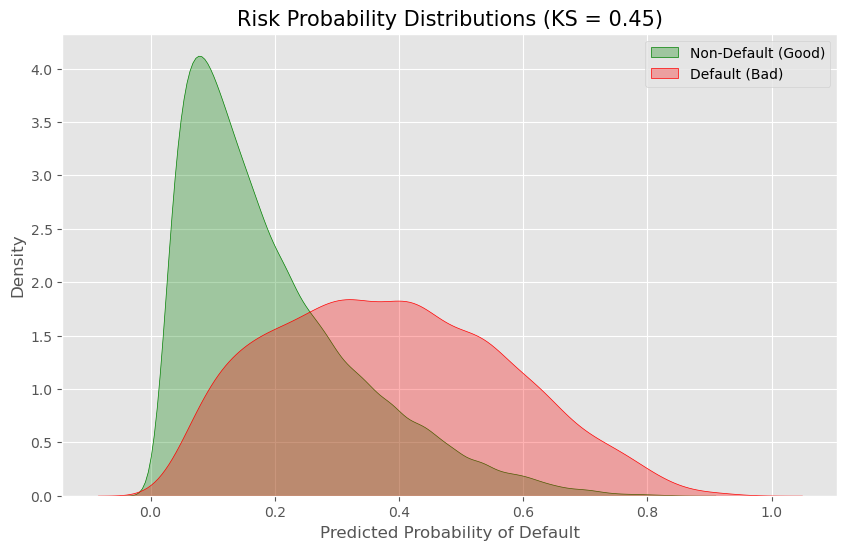


🧠 Calculating SHAP Values (This might take 1-2 mins)...


c:\Users\harsh\anaconda3\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


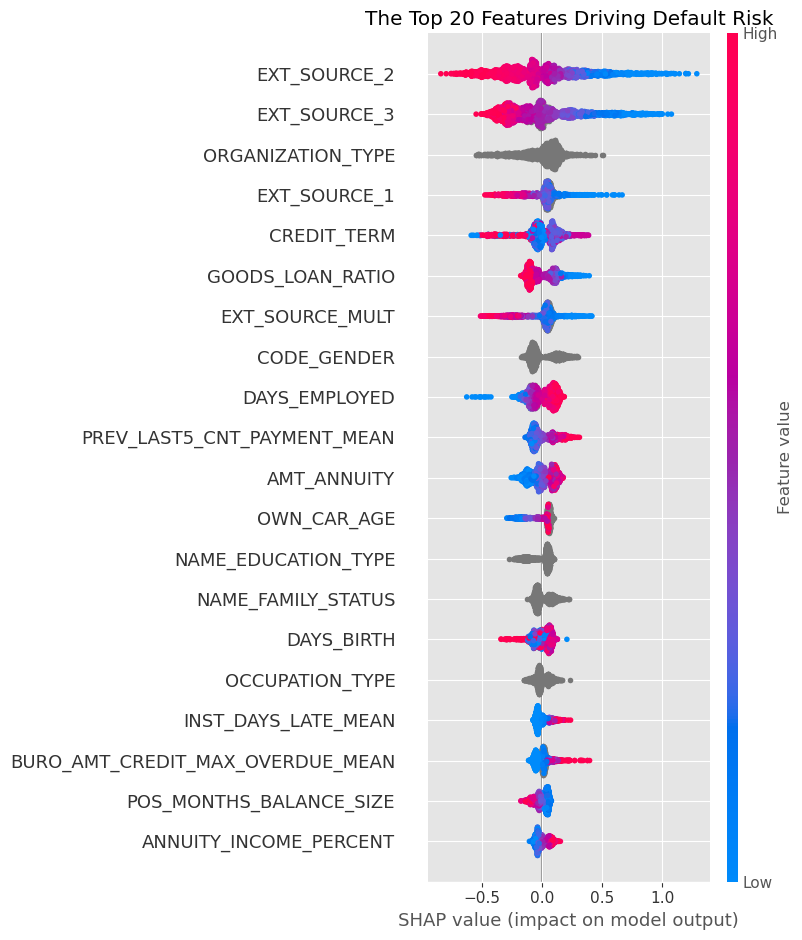

🔍 Example Decision Path for one user:


IndexError: invalid index to scalar variable.

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
import shap

print("📊 Starting Post-Modeling Analytics...")

# --- 1. KS Statistic (The "Separation" Power) ---
# KS measures the max distance between the Good and Bad distribution curves.
# Industry Standard: 40% - 60% is excellent. Above 60% might be overfitting.

# Get predictions for Default (Class 1) and Non-Default (Class 0)
preds_bad = final_blend[y_valid == 1]
preds_good = final_blend[y_valid == 0]

# Calculate KS
ks_stat, p_value = ks_2samp(preds_bad, preds_good)

print("-" * 30)
print(f"📈 KS Statistic: {ks_stat * 100:.2f}%")
print("-" * 30)
if ks_stat > 0.40:
    print("✅ The model has EXCELLENT separation power.")
else:
    print("⚠️ The model separation is moderate.")

# Plot the KS Curve (Visual Proof)
plt.figure(figsize=(10, 6))
sns.kdeplot(preds_good, label='Non-Default (Good)', fill=True, color='green', alpha=0.3)
sns.kdeplot(preds_bad, label='Default (Bad)', fill=True, color='red', alpha=0.3)
plt.title(f'Risk Probability Distributions (KS = {ks_stat:.2f})', fontsize=15)
plt.xlabel('Predicted Probability of Default')
plt.ylabel('Density')
plt.legend()
plt.show()

# --- 2. SHAP Analysis (The "Why") ---
# We use the LightGBM model for explainability (it drives 60% of the decision)

print("\n🧠 Calculating SHAP Values (This might take 1-2 mins)...")

# Take a sample (SHAP is heavy on the full dataset)
X_shap_sample = X_valid.sample(n=2000, random_state=42)

# Create the explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap_sample)

# Handle LightGBM's list output (it returns [Class0, Class1])
if isinstance(shap_values, list):
    shap_vals = shap_values[1] # We want reasons for "Default" (Class 1)
else:
    shap_vals = shap_values

# 2A. Summary Plot (The Global Drivers)
plt.figure(figsize=(12, 10))
plt.title("The Top 20 Features Driving Default Risk")
shap.summary_plot(shap_vals, X_shap_sample, max_display=20)

# 2B. Individual Force Plot (Optional - for a specific user)
# This shows why User #0 was rejected/accepted
print("🔍 Example Decision Path for one user:")
shap.initjs()
display(shap.force_plot(explainer.expected_value[1], shap_vals[0,:], X_shap_sample.iloc[0,:]))

🔍 Generatng SHAP Force Plot (Fixed)...


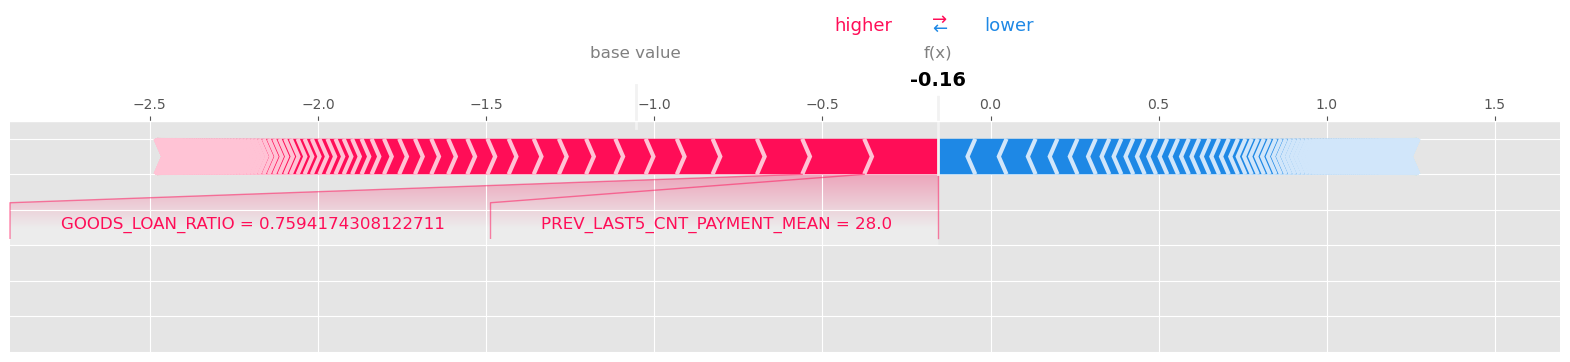

In [52]:
import shap

print("🔍 Generatng SHAP Force Plot (Fixed)...")

# 1. Handle the "Expected Value" (Base Value) safely
base_value = explainer.expected_value

# Check if it's a list/array (Old SHAP) or a number (New SHAP)
if isinstance(base_value, list) or isinstance(base_value, np.ndarray):
    # If it's a list, we want the second value (Class 1 / Default)
    base_value = base_value[1]
else:
    # If it's just a number, use it directly
    base_value = base_value

# 2. Plot
shap.initjs()
# shap_vals[0,:] is the SHAP values for the first customer in our sample
# X_shap_sample.iloc[0,:] is the actual data for that customer
shap.force_plot(base_value, shap_vals[0,:], X_shap_sample.iloc[0,:], matplotlib=True)

🧠 Initiating Deep SHAP Analysis...


c:\Users\harsh\anaconda3\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


✅ SHAP Values Calculated.


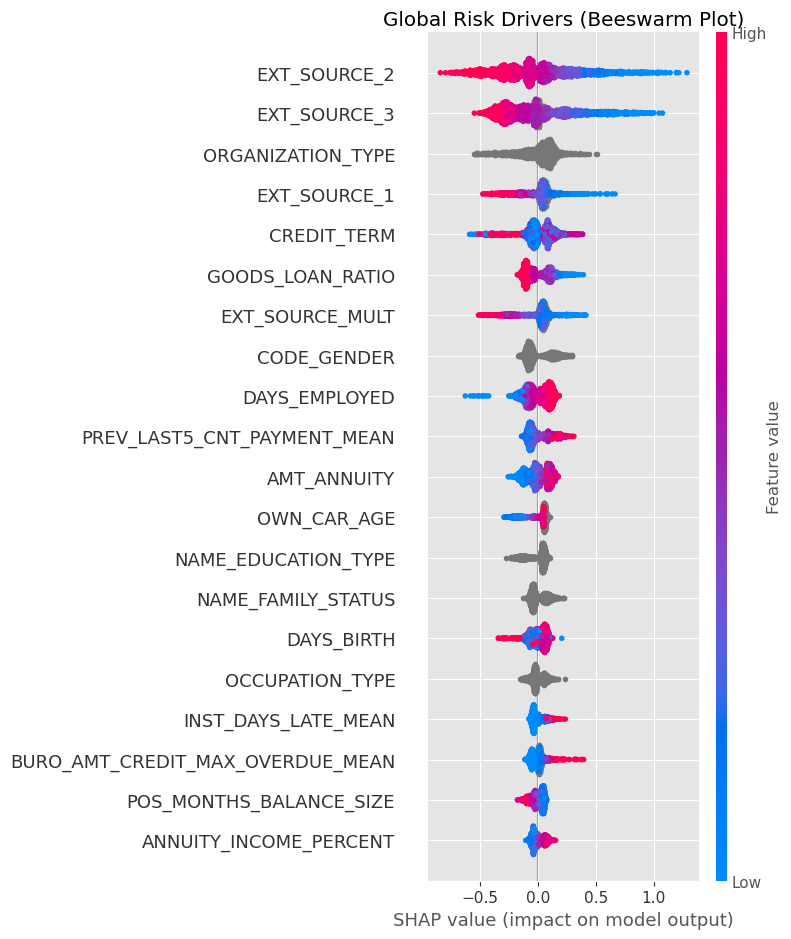

🔍 analyzing Interaction: External Sources...


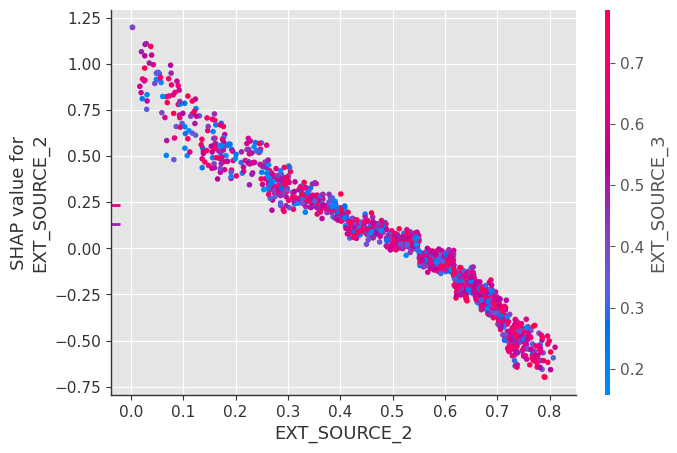

🔍 Analyzing Interaction: B_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM vs AMT_INCOME_TOTAL...


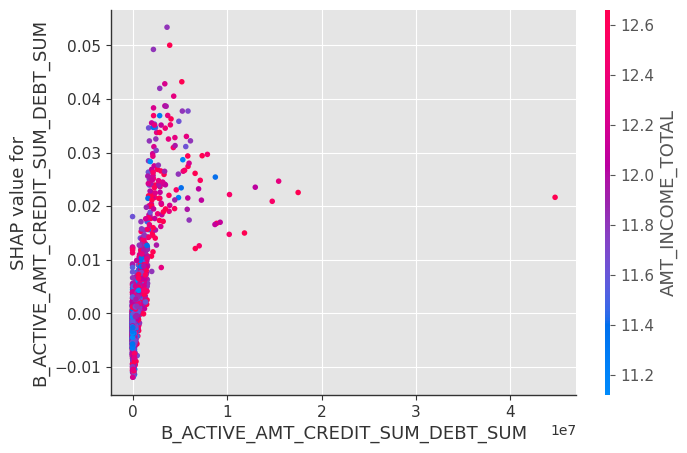

🔍 Analyzing Riskiest Customer in Sample (Index: 1844)
   Predicted Risk: 92.25%


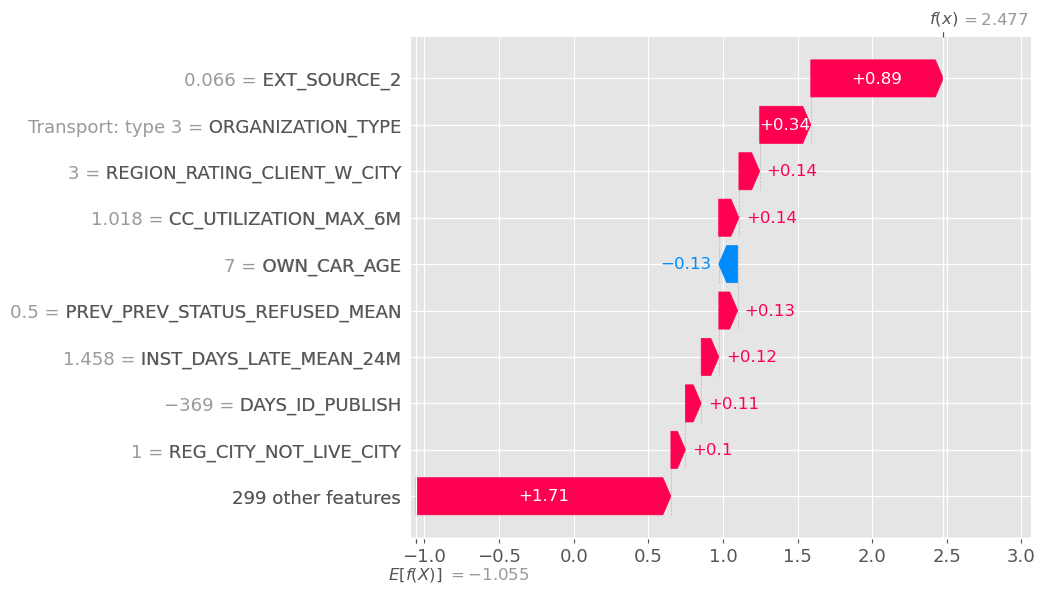

In [55]:
import shap
import matplotlib.pyplot as plt
import numpy as np

print("🧠 Initiating Deep SHAP Analysis...")

# 1. Prepare the Explainer (LightGBM)
# We use a sample of 2000 rows to keep it fast but accurate
X_shap = X_valid.sample(n=2000, random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

# Compatibility Fix: LightGBM sometimes returns a list [Class0, Class1]
# We want Class 1 (Default Risk)
if isinstance(shap_values, list):
    shap_values_risk = shap_values[1]
    base_value = explainer.expected_value[1]
else:
    shap_values_risk = shap_values
    base_value = explainer.expected_value

print("✅ SHAP Values Calculated.")

# --- LEVEL 1: GLOBAL VIEW (The "Beeswarm") ---
# This shows the Top 20 features and how they impact risk
plt.figure(figsize=(12, 10))
plt.title("Global Risk Drivers (Beeswarm Plot)")
shap.summary_plot(shap_values_risk, X_shap, max_display=20, show=False)
plt.tight_layout()
plt.show()

# --- LEVEL 2: INTERACTION VIEW (Dependence Plots) ---
# Let's look at your "Nuclear" and "Megaset" features specifically
# 1. EXT_SOURCE_2 vs. EXT_SOURCE_3 (The Classic Interaction)
print("🔍 analyzing Interaction: External Sources...")
shap.dependence_plot("EXT_SOURCE_2", shap_values_risk, X_shap, interaction_index="EXT_SOURCE_3")

# 2. ACTIVE DEBT vs. INCOME (The "Megaset" Insight)
# Check if we have the 'B_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN' feature (or similar from your Megaset)
# We try to find the best match in your columns
debt_cols = [c for c in X.columns if 'ACTIVE' in c and 'DEBT' in c]
income_col = 'AMT_INCOME_TOTAL'

if debt_cols and income_col in X.columns:
    primary_feat = debt_cols[0] # Pick the first Active Debt feature
    print(f"🔍 Analyzing Interaction: {primary_feat} vs {income_col}...")
    shap.dependence_plot(primary_feat, shap_values_risk, X_shap, interaction_index=income_col)


# --- LEVEL 3: LOCAL VIEW (The "Waterfall") ---
# Explain exactly why the RISKIEST customer in our sample was flagged
# Find index of highest risk prediction in our sample
risk_scores = model.predict(X_shap)
riskiest_idx = np.argmax(risk_scores)

print(f"🔍 Analyzing Riskiest Customer in Sample (Index: {riskiest_idx})")
print(f"   Predicted Risk: {risk_scores[riskiest_idx]:.2%}")

# Generate Waterfall
plt.figure(figsize=(10, 10))
shap.plots.waterfall(
    shap.Explanation(values=shap_values_risk[riskiest_idx], 
                     base_values=base_value, 
                     data=X_shap.iloc[riskiest_idx], 
                     feature_names=X_shap.columns.tolist())
)
plt.show()